In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn as sk
import datetime
import dateutil
import copy 

%matplotlib inline

In [2]:
## read in data

tmp_USLC_Core= pd.read_excel('USLargeCapCore_input.xlsx', sheet_name='USLCC_Rets',index_col=0, na_values=' ')
tmp_USLC_Value= pd.read_excel( 'USLargeCapValue_input.xlsm', sheet_name= 'USLCV_Rets', index_col= 0, na_values=' ')
tmp_USLC_Growth= pd.read_excel( 'USLargeCapGrowth_input.xlsm', sheet_name= 'USLCG_Rets', index_col= 0, na_values=' ')

tmp_BenchMark= pd.read_excel( 'USLargeCapCore_input.xlsx', sheet_name= 'AllBenchmark_Ret', index_col= 0, na_values=' ')

tmp_USLC_Core.columns= [str(x) for x in tmp_USLC_Core.columns]
tmp_USLC_Value.columns= [str(x) for x in tmp_USLC_Value.columns]
tmp_USLC_Growth.columns= [str(x) for x in tmp_USLC_Growth.columns]


## 
tmp_USLC_Core.drop( columns= tmp_USLC_Core.columns[np.logical_or( tmp_USLC_Core.count(axis=0)<= 12*5, 
                                                                tmp_USLC_Core.loc['InvestmentApproach', ].isna()) ], inplace= True)
tmp_USLC_Value.drop( columns= tmp_USLC_Value.columns[np.logical_or( tmp_USLC_Value.count( axis=0)<= 12*5, 
                                                                  tmp_USLC_Value.loc['InvestmentApproach', ].isna() )], inplace= True)
tmp_USLC_Growth.drop( columns=tmp_USLC_Growth.columns[np.logical_or( tmp_USLC_Growth.count(axis=0)<= 12*5, 
                                                                   tmp_USLC_Growth.loc['InvestmentApproach', ].isna() )], inplace= True)


class EVFUND (object):
    
    def __init__(self, EID, ret, approach, category, company, vehicle,  benchmark= None): 
        self.EID= EID
        self.ret= ret.dropna()
        self.ret.name= self.EID
        self.benchmark= benchmark
        self.category= category
        self.company= company
        self.vehicle= vehicle
        
        self.fundStart= self.ret.index[0]
        self.fundStart= datetime.date( self.fundStart.year, self.fundStart.month, self.fundStart.day)
        self.fundEnd= self.ret.index[-1]
        self.fundEnd= datetime.date( self.fundEnd.year, self.fundEnd.month, self.fundEnd.day)
        
        self.hasBreak= False
        t= dateutil.relativedelta.relativedelta( self.fundEnd, self.fundStart)
        MonthCount= t.years*12 + t.months+1
        if MonthCount!= self.ret.shape[0]:
            self.hasBreak= True
            s= ~ ret.isnull()
            a1= s.idxmax()
            s= ~ ret[ret.index[::-1]].isnull()
            a2= s.idxmax()
            self.fundStart= a1
            self.fundEnd= a2
            self.ret= ret.loc[ a1:a2].fillna(0)
            self.ret.name= self.EID
            
            self.fundStart= datetime.date( self.fundStart.year, self.fundStart.month, self.fundStart.day)
            self.fundEnd= datetime.date( self.fundEnd.year, self.fundEnd.month, self.fundEnd.day)
        
        self.approach= approach
        
        self.annualRet= (self.ret+1).prod()** (12/self.ret.shape[0])-1
        self.annualVol= self.ret.std()*np.sqrt(12)
        
        self.excessRet= None
        self.activeVol= None
        if self.benchmark is not None:
            self.excessRet= (self.ret- self.benchmark.ret).dropna().mean()* 12
            self.activeVol= (self.ret- self.benchmark.ret).dropna().std() * np.sqrt(12)
            
            
BM_Index= { 'R1000': EVFUND( EID= 'R1000', approach=None, category=None, company= None, vehicle=None ,ret= tmp_BenchMark['R1000']), 
          'R1000V': EVFUND( EID= 'R1000V', approach= None, category= None, company= None, vehicle= None, ret= tmp_BenchMark['R1000V']), 
          'R1000G': EVFUND( EID= 'R1000G', approach= None, category= None, company= None, vehicle= None, ret= tmp_BenchMark['R1000G'])}

USLC_CoreFund= {k: EVFUND(EID=k, 
                          approach=tmp_USLC_Core.loc[ 'InvestmentApproach', k], 
                          company= tmp_USLC_Core.loc['Company', k], 
                          vehicle= tmp_USLC_Core.loc['Vehicle', k], 
                          category= 'USLC_Core',
                          ret= tmp_USLC_Core.iloc[ 4:, ][k],
                          benchmark= BM_Index['R1000']
                         )  for k in tmp_USLC_Core.columns}

USLC_ValueFund= {k: EVFUND(EID=k ,
                           approach= tmp_USLC_Value.loc[ 'InvestmentApproach' ,k ],
                           company= tmp_USLC_Value.loc[ 'Company', k],
                           vehicle= tmp_USLC_Value.loc['Vehicle', k],
                           category= 'USLC_Value',
                           ret= tmp_USLC_Value.iloc[ 4:, ][k], 
                           benchmark= BM_Index['R1000V']
                          )for k in tmp_USLC_Value.columns}

USLC_GrowthFund= {k: EVFUND(EID= k, 
                            approach= tmp_USLC_Growth.loc['InvestmentApproach', k],
                            company= tmp_USLC_Growth.loc[ 'Company', k],
                            vehicle= tmp_USLC_Growth.loc['Vehicle', k],
                            category= 'USLC_Growth',
                            ret= tmp_USLC_Growth.iloc[ 4:, ][k],
                            benchmark= BM_Index['R1000G']
                           )  for k in tmp_USLC_Growth.columns}


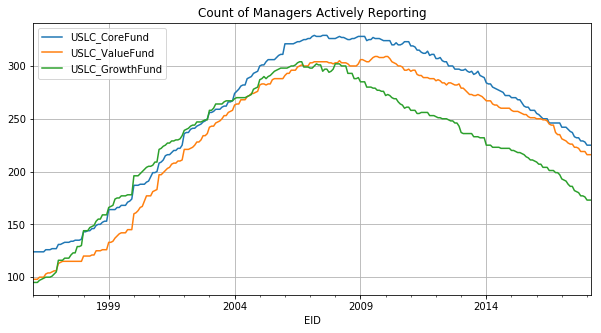

In [3]:
USLC_Core_Ret= pd.DataFrame({k:v.ret for k,v in USLC_CoreFund.items()})
USLC_Value_Ret= pd.DataFrame( {k: v.ret for k,v in USLC_ValueFund.items()})
USLC_Growth_Ret= pd.DataFrame( {k: v.ret for k,v in USLC_GrowthFund.items() })

t= pd.DataFrame({'USLC_CoreFund': USLC_Core_Ret.count(axis=1), 
                'USLC_ValueFund': USLC_Value_Ret.count(axis=1), 
                'USLC_GrowthFund': USLC_Growth_Ret.count( axis=1)},)
t= t.loc[t.index<=  '2018-03-31', ]

t.plot(figsize= (10, 5))
plt.grid()
plt.title('Count of Managers Actively Reporting')
plt.savefig('evfund1.jpg')

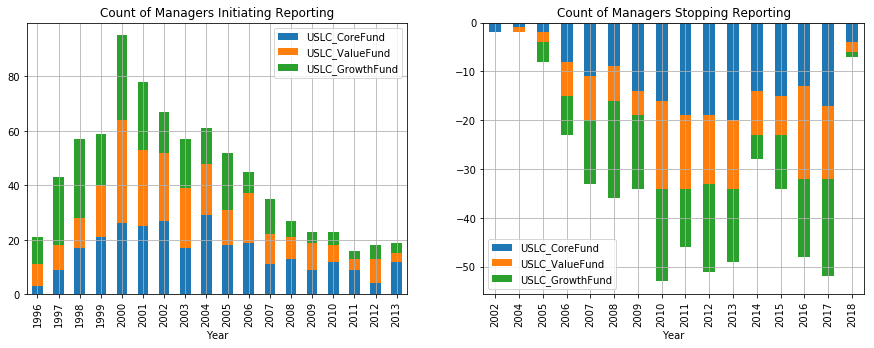

In [4]:
pd.DataFrame({k: {v.fundStart: 1} for k, v in USLC_CoreFund.items() }).count( axis=1).sort_index()

t1= pd.DataFrame( {'USLC_CoreFund': pd.DataFrame({k: {v.fundStart:1} for k,v  in USLC_CoreFund.items()}).count(axis=1), 
                  'USLC_ValueFund': pd.DataFrame( {k: {v.fundStart:1} for k,v in USLC_ValueFund.items()}).count(axis=1), 
                  'USLC_GrowthFund': pd.DataFrame( {k:{v.fundStart:1} for k,v in USLC_GrowthFund.items()}).count(axis=1)}).sort_index().fillna(0)
t1= t1.loc[ np.logical_and( t1.index>datetime.date(1996, 1,31), t1.index<= datetime.date(2018,3,31) ), ]
t1['Year']= [x.year for x in t1.index]
t1= t1.groupby(['Year']).sum()

t2= pd.DataFrame( {'USLC_CoreFund': pd.DataFrame({k: {v.fundEnd:1 } for k,v in USLC_CoreFund.items() }).count(axis=1), 
                  'USLC_ValueFund': pd.DataFrame({k: {v.fundEnd:1 } for k,v in USLC_ValueFund.items()}).count(axis=1), 
                  'USLC_GrowthFund': pd.DataFrame({k: {v.fundEnd:1} for k, v in USLC_GrowthFund.items()}).count(axis=1)}).sort_index().fillna(0)
t2= t2.loc[np.logical_and( t2.index> datetime.date( 1996,1,31), t2.index<= datetime.date(2018, 3,31))]
t2['Year']= [x.year for x in t2.index]
t2= t2.groupby(['Year']).sum()* -1


plt.figure( figsize=( 15, 5))

ax= plt.subplot(121)
t1.plot.bar(stacked= True, ax= ax)
ax.grid()
ax.set_title('Count of Managers Initiating Reporting')
ax= plt.subplot(122)
t2.plot.bar( stacked= True, ax= ax)
ax.grid()
ax.set_title('Count of Managers Stopping Reporting')
plt.savefig('evfund2.jpg')

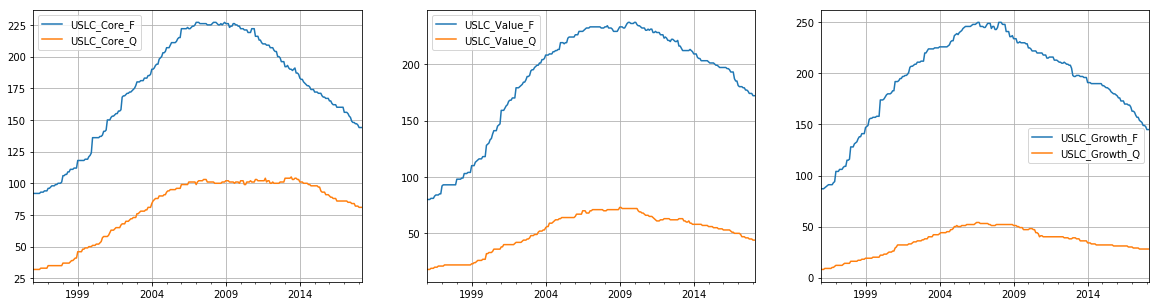

In [5]:
t1= pd.concat( [USLC_Core_Ret, pd.DataFrame(pd.Series({k: v.approach for k,v in USLC_CoreFund.items()}, name= 'Approach' )).T.fillna('Mixed')], axis=0).T
t1= t1.groupby( ['Approach']).apply(lambda x: x.drop( columns= ['Approach']).T.count( axis=1)).T
t1.columns= ['USLC_Core_'+ x for x in t1.columns]
t1= t1.loc[ np.logical_and(t1.index>= '1996-01-31', t1.index<='2018-03-31'), ]

t2= pd.concat( [USLC_Value_Ret, pd.DataFrame(pd.Series( {k:v.approach for k,v in USLC_ValueFund.items()} , name= 'Approach')).T.fillna( 'Mixed')], axis=0).T
t2= t2.groupby( ['Approach']).apply( lambda x : x.drop( columns=['Approach']).T. count( axis=1)).T
t2.columns= ['USLC_Value_'+ x for x in t2.columns]
t2= t2.loc[ np.logical_and( t2.index>='1996-01-31', t2.index<= '2018-03-31'), ]

t3= pd.concat( [USLC_Growth_Ret, pd.DataFrame(pd.Series({k:v.approach for k,v in USLC_GrowthFund.items() }, name= 'Approach')).T.fillna( 'Mixed')], axis=0 ).T
t3= t3.groupby( ['Approach']).apply( lambda x : x.drop( columns= ['Approach']).T. count(axis=1)).T
t3.columns= ['USLC_Growth_'+ x for x in t3.columns]
t3=t3.loc[np.logical_and( t3.index>= '1996-01-31', t3.index<= '2018-03-31'), ]

plt.figure( figsize=( 20, 5))

ax= plt.subplot(131)
t1.plot( ax= ax)
ax.grid()
ax= plt.subplot(132)
t2.plot(ax=ax)
ax.grid()
ax= plt.subplot(133)
t3.plot(ax=ax)
ax.grid()

plt.savefig('evfund3.jpg')

### Are the TE ranking persistant?  (36M TE)

In [6]:
# Evaluate the TE ranking in each (Universe, Approach) combination every month. The evaluation period is 36M. 
# Managers with history not long enought is ignored
# Starts from period (1997-1-1, 1999-12-31). The rolling step is 12 months. 

from scipy import stats

month_list=[datetime.date(x, 1,31) for x in range(2000, 2019, 1)]


tmp_Funddict= {** USLC_CoreFund, **USLC_ValueFund, **USLC_GrowthFund}

TE_36MAbsDict= {}


def helper_TE (fund_obj, startDate, endData):
    
    if fund_obj.fundStart> startDate:
         return None
    else: 
        a= fund_obj.ret- fund_obj.benchmark.ret
        a= a.loc[np.logical_and(a.index>= startDate.strftime('%Y-%m-%d'), a.index<=endData.strftime('%Y-%m-%d')), ]
        
        return a.std()* (12**.5)
    
    
for t in month_list: 
    
    tStart= t+ dateutil.relativedelta.relativedelta(years= -3, day= 31)
    tEnd= t
    
    abs_df= pd.DataFrame({k: {'Universe': v.category, 
                             'Approach': v.approach, 
                             'TE': helper_TE (v, startDate= tStart, endData= tEnd)} for k,v in tmp_Funddict.items()}).T.dropna()
    rel_df= []
    for k, v in abs_df.groupby(['Universe', 'Approach']):
        c= copy.deepcopy(v)
        c['TE_gRank']= [stats.percentileofscore(c['TE'], x )/100 for x in c['TE']]
        c['EvaluationDate']= tEnd
        c.index.name= 'FundID'
        c.reset_index(inplace=True)
        rel_df.append(c)
        
    
    
    TE_36MAbsDict[tEnd]= pd.concat(rel_df)
    
    



In [7]:
TE_36MAbsDict.keys()

dict_keys([datetime.date(2000, 1, 31), datetime.date(2001, 1, 31), datetime.date(2002, 1, 31), datetime.date(2003, 1, 31), datetime.date(2004, 1, 31), datetime.date(2005, 1, 31), datetime.date(2006, 1, 31), datetime.date(2007, 1, 31), datetime.date(2008, 1, 31), datetime.date(2009, 1, 31), datetime.date(2010, 1, 31), datetime.date(2011, 1, 31), datetime.date(2012, 1, 31), datetime.date(2013, 1, 31), datetime.date(2014, 1, 31), datetime.date(2015, 1, 31), datetime.date(2016, 1, 31), datetime.date(2017, 1, 31), datetime.date(2018, 1, 31)])

In [8]:
a= pd.concat(TE_36MAbsDict.values(), axis= 0)

b= a.groupby(['Universe', 'Approach','FundID'] ).mean() 
b= b.reset_index()
b['TE_level']= ['L' if x<0.6 else 'H'  for x in b.TE_gRank]

print(b.groupby( ['Universe', 'Approach', 'TE_level']).count()) 


for k,v in {**USLC_CoreFund, **USLC_ValueFund, **USLC_GrowthFund}.items():
    v.TE_TercileWUA= b.loc[b.FundID==v.EID, 'TE_level'].values[0]

                               FundID  TE_gRank
Universe    Approach TE_level                  
USLC_Core   F        H            107       107
                     L            162       162
            Q        H             60        60
                     L             76        76
USLC_Growth F        H             99        99
                     L            190       190
            Q        H             23        23
                     L             37        37
USLC_Value  F        H            104       104
                     L            173       173
            Q        H             31        31
                     L             51        51


In [9]:
# How persistent the TE classification

c= a.merge( right= b[['FundID', 'TE_level']], on= 'FundID', how= 'left')
c['cur_TE_level']= c.TE_gRank.apply( lambda x: 'H' if x >0.6 else 'L')
c['cur_Cross']= (c.TE_level!= c.cur_TE_level).astype(int)
c['apperance_count']=1
d= c.groupby( ['FundID', 'TE_level']).sum()[['cur_Cross', 'apperance_count']]
d['crossPct']= d.cur_Cross/ d.apperance_count
d.reset_index(inplace=True)
d.head(10)

,FundID,TE_level,cur_Cross,apperance_count,crossPct
0,1002943,H,1,5,0.200000
1,1004326,L,0,8,0.000000
2,1008488,L,0,2,0.000000
3,1079917,L,0,11,0.000000
4,1093129,H,4,14,0.285714
5,1096719,H,0,4,0.000000
6,1097598,H,0,19,0.000000
7,1099755,L,2,19,0.105263
8,1099803,H,0,5,0.000000
9,1107829,L,2,19,0.105263


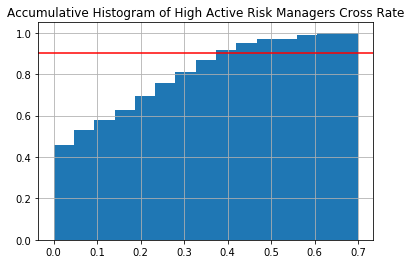

In [10]:
plt.hist(  d.loc[d.TE_level=='H', 'crossPct'], density=True, cumulative=True, bins= 15, histtype= 'bar', )
plt.grid()
plt.axhline( 0.9, c= 'red')
plt.title('Accumulative Histogram of High Active Risk Managers Cross Rate')

plt.savefig('highte_cross.jpg')

More than 90% managers classified as 'High' TE stay in the 'High' territory more than 60% of the time.

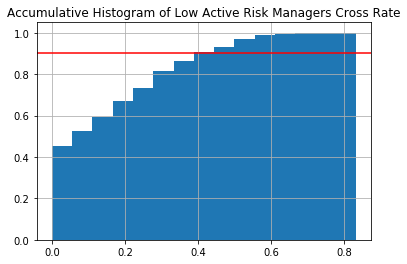

In [11]:
plt.hist(  d.loc[d.TE_level=='L', 'crossPct'], density=True, cumulative=True, bins= 15, histtype= 'bar', )
plt.grid()
plt.axhline( 0.9, c= 'red')
plt.title('Accumulative Histogram of Low Active Risk Managers Cross Rate')
plt.savefig('lowte_cross.jpg')


More than 90% managers classified as 'Low' TE stay in the 'Low' territory more than 60% of the time


The high/low tracking error classification within each *Universe+Approach* group is persistent. If the hypothesis that investor can digest the tracking error classification information from portfolio manager interview with good confidence is accepted, we can use the tracking error information to further group and analyze the manager behavior and performance. 

In [12]:
t1= pd.DataFrame({k: {'ReportLength': v.ret.shape[0], 'StartDate': v.fundStart, 'EndDate': v.fundEnd, 
                          'ExcRet': v.excessRet, 'TE': v.activeVol,
                          'Universe': 'USLC_Core', 
                          'Approach': v.approach,
                     'TE_level': v.TE_TercileWUA} for k,v in USLC_CoreFund.items() }).T.fillna('Mixed')
t2= pd.DataFrame({k: {'ReportLength': v.ret.shape[0], 'StartDate': v.fundStart, 'EndDate': v.fundEnd, 
                          'ExcRet': v.excessRet, 'TE': v.activeVol,
                          'Universe': 'USLC_Value', 
                          'Approach': v.approach, 
                     'TE_level': v.TE_TercileWUA} for k,v in USLC_ValueFund.items() }).T.fillna( 'Mixed')
t3= pd.DataFrame({k: {'ReportLength': v.ret.shape[0], 'StartDate': v.fundStart, 'EndDate': v.fundEnd, 
                          'ExcRet': v.excessRet, 'TE': v.activeVol,
                          'Universe': 'USLC_Growth', 
                          'Approach': v.approach,
                     'TE_level': v.TE_TercileWUA} for k,v in USLC_GrowthFund.items() }).T.fillna('Mixed')

u= pd.concat( [t1, t2, t3], axis=0)


u.groupby(['Universe', 'Approach', 'TE_level']).mean()


ExcRet  ReportLength        TE
Universe    Approach TE_level                                  
USLC_Core   F        H         0.014360    167.803738  0.065637
                     L         0.004065    180.111111  0.038140
            Q        H         0.008980    142.750000  0.062255
                     L         0.005391    174.723684  0.026150
USLC_Growth F        H         0.020916    171.111111  0.083656
                     L         0.010214    185.605263  0.054971
            Q        H         0.022032    150.652174  0.092737
                     L         0.006402    162.513514  0.033156
USLC_Value  F        H         0.014030    168.153846  0.067292
                     L         0.006374    189.647399  0.040428
            Q        H         0.014441    161.870968  0.054786
                     L         0.007900    172.019608  0.030033

In [13]:
u

,Approach,EndDate,ExcRet,ReportLength,StartDate,TE,TE_level,Universe
686355,F,2018-06-30,-0.005400,188,2002-11-30,0.026603,L,USLC_Core
674988,F,2011-09-30,-0.022385,64,2006-06-30,0.064182,H,USLC_Core
620559,Q,2017-09-30,0.004705,159,2004-07-31,0.041260,H,USLC_Core
786786,Q,2018-06-30,0.011268,270,1996-01-31,0.039878,L,USLC_Core
820161,Q,2018-06-30,-0.004925,137,2007-02-28,0.028249,L,USLC_Core
803006,F,2018-06-30,0.032658,162,2005-01-31,0.035990,L,USLC_Core
605249,F,2017-09-30,-0.003349,189,2002-01-31,0.028739,L,USLC_Core
1149642,Q,2018-06-30,-0.003906,70,2012-09-30,0.016268,L,USLC_Core
604031,F,2018-06-30,0.014825,270,1996-01-31,0.042375,L,USLC_Core
622790,Q,2018-06-30,0.034907,154,2005-09-30,0.060810,H,USLC_Core


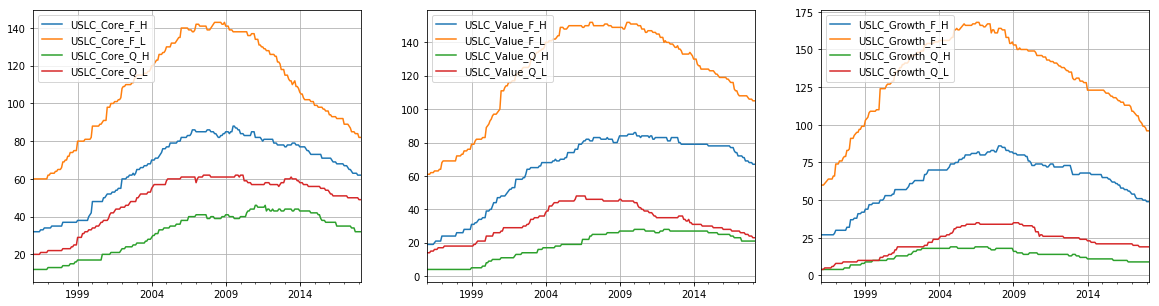

In [14]:
# reproduce the chart with TE info

t1= pd.concat( [USLC_Core_Ret, 
                pd.DataFrame({k: {'Approach': v.approach, 'TE': v.TE_TercileWUA} for k,v in USLC_CoreFund.items() })
               ], axis=0).T
t1= t1.groupby( ['Approach', 'TE']).apply(lambda x: x.drop( columns= ['Approach', 'TE']).T.count( axis=1)).T
t1.columns= ['USLC_Core_'+ '_'.join(x) for x in t1.columns]
t1= t1.loc[ np.logical_and(t1.index>= '1996-01-31', t1.index<='2018-03-31'), ]

t2= pd.concat( [USLC_Value_Ret, 
                pd.DataFrame({k: {'Approach': v.approach, 'TE': v.TE_TercileWUA} for k,v in USLC_ValueFund.items() })
               ], axis=0).T
t2= t2.groupby( ['Approach', 'TE']).apply( lambda x : x.drop( columns=['Approach', 'TE']).T. count( axis=1)).T
t2.columns= ['USLC_Value_'+ '_'.join(x) for x in t2.columns]
t2= t2.loc[ np.logical_and( t2.index>='1996-01-31', t2.index<= '2018-03-31'), ]

t3= pd.concat( [USLC_Growth_Ret, 
                pd.DataFrame({k: {'Approach': v.approach, 'TE': v.TE_TercileWUA} for k,v in USLC_GrowthFund.items() })
               ], axis=0).T
t3= t3.groupby( ['Approach','TE']).apply( lambda x : x.drop( columns= ['Approach', 'TE']).T. count(axis=1)).T
t3.columns= ['USLC_Growth_'+ '_'.join(x) for x in t3.columns]
t3=t3.loc[np.logical_and( t3.index>= '1996-01-31', t3.index<= '2018-03-31'), ]

plt.figure( figsize=( 20, 5))

ax= plt.subplot(131)
t1.plot( ax= ax)
ax.grid()
ax= plt.subplot(132)
t2.plot(ax=ax)
ax.grid()
ax= plt.subplot(133)
t3.plot(ax=ax)
ax.grid()

plt.savefig( 'count_mgrs_allg.jpg')

In [15]:
# writer= pd.ExcelWriter('manager_count.xlsx')
# pd.concat( [t1, t2, t3], axis=1).to_excel(writer)
# writer.save()

### ANOVA Analysis (Univserse + Approach)

In [16]:
from statsmodels.formula.api import ols
import pickle

tmp_reg= ols( 'ExcRet~ C(Universe, Sum)', data= u).fit()
print(sm.stats.anova_lm( tmp_reg,typ=2))
pickle.dump( tmp_reg, open( 'anova_style1.p', 'wb'))
print(tmp_reg.summary())
tmp_reg= ols( 'TE~ C(Universe, Sum)', data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ=2))
pickle.dump(tmp_reg, open( 'anova_style2.p', 'wb'))
print(tmp_reg.summary())

                    sum_sq      df          F    PR(>F)
C(Universe, Sum)  0.006672     2.0  12.416577  0.000005
Residual          0.298230  1110.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                 ExcRet   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     12.42
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           4.64e-06
Time:                        11:35:14   Log-Likelihood:                 2997.8
No. Observations:                1113   AIC:                            -5990.
Df Residuals:                    1110   BIC:                            -5974.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef

In [17]:
tmp_reg= ols( 'ExcRet~ C(Approach, Sum)',data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ=2))
print(tmp_reg.summary())
pickle.dump( tmp_reg, open( 'anova_appo1.p', 'wb'))
tmp_reg= ols( 'TE~ C(Approach, Sum)', data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ=2))
pickle.dump( tmp_reg, open('anova_appo2.p', 'wb'))
print(tmp_reg.summary())

                    sum_sq      df         F    PR(>F)
C(Approach, Sum)  0.000383     1.0  1.395785  0.237683
Residual          0.304520  1111.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                 ExcRet   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.396
Date:                Tue, 16 Jul 2019   Prob (F-statistic):              0.238
Time:                        11:35:15   Log-Likelihood:                 2986.2
No. Observations:                1113   AIC:                            -5968.
Df Residuals:                    1111   BIC:                            -5958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err  

In [18]:
tmp_reg= ols( 'ExcRet~ C(TE_level, Sum)', data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ=2))

pickle.dump( tmp_reg, open('anova_te1.p', 'wb'))
print( tmp_reg.summary())

tmp_reg= ols( 'TE~ C(TE_level, Sum)', data= u).fit()
print( sm.stats.anova_lm( tmp_reg, typ=2))
pickle.dump( tmp_reg, open('anova_te2.p', 'wb'))
print( tmp_reg.summary())


                    sum_sq      df          F        PR(>F)
C(TE_level, Sum)  0.019298     1.0  75.068473  1.580897e-17
Residual          0.285605  1111.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                 ExcRet   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     75.07
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.58e-17
Time:                        11:35:16   Log-Likelihood:                 3021.8
No. Observations:                1113   AIC:                            -6040.
Df Residuals:                    1111   BIC:                            -6030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            co

In [19]:
# Check the interaction

tmp_reg= ols( 'ExcRet~ C(TE_level, Sum)* C(Approach, Sum)* C(Universe, Sum)', data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ=2))
print(tmp_reg.summary())


tmp_reg= ols( 'TE~ C(TE_level, Sum)* C(Approach, Sum)* C(Universe, Sum)',data= u).fit()

print(sm.stats.anova_lm( tmp_reg, typ=2))

                                                      sum_sq      df  \
C(TE_level, Sum)                                    0.020680     1.0   
C(Approach, Sum)                                    0.000135     1.0   
C(Universe, Sum)                                    0.007447     2.0   
C(TE_level, Sum):C(Approach, Sum)                   0.000236     1.0   
C(TE_level, Sum):C(Universe, Sum)                   0.000749     2.0   
C(Approach, Sum):C(Universe, Sum)                   0.000332     2.0   
C(TE_level, Sum):C(Approach, Sum):C(Universe, Sum)  0.001057     2.0   
Residual                                            0.275100  1101.0   

                                                            F        PR(>F)  
C(TE_level, Sum)                                    82.766379  4.212602e-19  
C(Approach, Sum)                                     0.539863  4.626461e-01  
C(Universe, Sum)                                    14.902833  4.109966e-07  
C(TE_level, Sum):C(Approach, Sum)      

In [20]:
tmp_reg= ols('ExcRet~ C(Universe, Sum)*C(Approach, Sum)',data= u).fit()
print( sm.stats.anova_lm(tmp_reg, typ=2))

tmp_reg= ols('TE~ C(Universe, Sum)* C(Approach, Sum)', data= u).fit()
print(sm.stats.anova_lm(tmp_reg, typ= 2))

                                     sum_sq      df          F    PR(>F)
C(Universe, Sum)                   0.006349     2.0  11.795572  0.000009
C(Approach, Sum)                   0.000059     1.0   0.220375  0.638847
C(Universe, Sum):C(Approach, Sum)  0.000257     2.0   0.478309  0.619959
Residual                           0.297914  1107.0        NaN       NaN
                                     sum_sq      df          F        PR(>F)
C(Universe, Sum)                   0.052973     2.0  45.450222  1.071115e-19
C(Approach, Sum)                   0.015469     1.0  26.543646  3.048734e-07
C(Universe, Sum):C(Approach, Sum)  0.000633     2.0   0.543480  5.808784e-01
Residual                           0.645118  1107.0        NaN           NaN


In [21]:
print(ols('ExcRet~ C(Universe, Sum)+ C(Approach, Sum)',data= u).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:                 ExcRet   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     8.345
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.73e-05
Time:                        11:35:17   Log-Likelihood:                 2997.9
No. Observations:                1113   AIC:                            -5988.
Df Residuals:                    1109   BIC:                            -5968.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Findings:

    1. Unvierse & TE_level are significant factors to group ExcRet, while Approach has no effect.
    2. Universe & TE_level & Approach are significant to group TE. 
    3. The interaction has limited effect to group, either for ExcRet or TE. 

### Factor Ret

In [22]:
import pickle

FF_FactorRet= pickle.load(open( 'FF_Factors.p', 'rb'))
FactorRet= pickle.load( open( 'FactorRet.p', 'rb'))


In [23]:
Ret_df= pd.concat([USLC_Core_Ret, USLC_Value_Ret, USLC_Growth_Ret], axis=1)
Ret_df= Ret_df.loc[np.logical_and(Ret_df.index>= '1996-01-31', Ret_df.index<= '2018-03-31'), ]
Ret_df=pd.concat( [Ret_df,
                   pd.DataFrame({k: {'Approach': v.approach,
                                     'Universe': v.category, 
                                     'TE_level': v.TE_TercileWUA} for k,v in {**USLC_CoreFund, **USLC_ValueFund, **USLC_GrowthFund}.items()})
                  ], axis=0)
Ret_df_group= Ret_df.T.groupby(['Universe', 'Approach', 'TE_level']).apply(lambda x: x.mean(axis=0)).T




In [24]:
# Wrap above analysis and produce a rolling analysis 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

def sfs_reg_wrapper (X, y, Factor_Count, ): 
    
    reg_lm= LinearRegression()
    
    sfs_model= SFS(reg_lm, 
                  k_features=Factor_Count, 
                  forward=True,
                    floating=True,
                  verbose=True,
                  cv=0).fit(X= X.values, 
                           y= y.values)
    reg= sm.OLS(endog= y, 
               exog= X.iloc[:, [int(x) for x in sfs_model.k_feature_names_]]).fit()
    return reg

# Rolling with window = 3y, moving step = 1y



Rolling_Starts= []
Rolling_Ends= []
t1= datetime.date(1996, 1, 31)
t2= t1+ dateutil.relativedelta.relativedelta(years= 3, months=-1, day= 31)
while t2<= datetime.date(2018, 1,31):
    Rolling_Starts.append(t1)
    Rolling_Ends.append(t2)
    
    t1= t1+ dateutil.relativedelta.relativedelta(years=1, day= 31)
    t2= t2+ dateutil.relativedelta.relativedelta(years=1, day= 31)
    
    
Universe_AvgRet= copy.deepcopy(Ret_df_group)
Universe_AvgRet.columns= ['_'.join(x) for x in Universe_AvgRet.columns]
df= pd.concat([Universe_AvgRet,
               pd.Series( BM_Index['R1000'].ret, name= 'R1000_ret'),
               pd.Series( BM_Index['R1000V'].ret, name= 'R1000V_ret'),
               pd.Series( BM_Index['R1000G'].ret, name= 'R1000G_ret'),
               FactorRet], axis=1)
df= df.loc[np.logical_and( df.index>= '1996-01-31', df.index<= '2018-03-31'), ]
Factor_Count = 7
RollingReg_UniverseFactorAnalysis= {}

for u in Universe_AvgRet.columns: 
    
    rolling_reg= {}
    
    for i in range( len(Rolling_Starts)): 
        y= df[u]
        y= y.loc[np.logical_and(y.index>= Rolling_Starts[i].strftime('%Y-%m-%d'), 
                               y.index<= Rolling_Ends[i].strftime('%Y-%m-%d'))]
        
        s= None
        g= u.split('_')[1]
        if g=='Core':
            s= ['R1000V_ret', 'R1000G_ret']
        elif g=='Value':
            s=['R1000_ret', 'R1000G_ret']
        else: 
            s= ['R1000_ret', 'R1000V_ret']
            
        X= df.drop(columns= list(Universe_AvgRet.columns) +s)
        X= X.loc[np.logical_and (X.index>= Rolling_Starts[i].strftime('%Y-%m-%d'), 
                                X.index<= Rolling_Ends[i].strftime('%Y-%m-%d')),: ]
        rolling_reg[Rolling_Ends[i]]= sfs_reg_wrapper (X= X, y=y, Factor_Count=6)
        
    
    RollingReg_UniverseFactorAnalysis[u]= rolling_reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend w

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend Sequen

Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequen

In [25]:
RollingReg_Beta= {k: pd.DataFrame({g: h.params.to_dict() for g, h in v.items()} ).T for k, v in RollingReg_UniverseFactorAnalysis.items()}
RollingReg_pVal= {k: pd.DataFrame({g: h.pvalues.to_dict() for g, h in v.items()} ).T for k, v in RollingReg_UniverseFactorAnalysis.items()}



In [26]:


Universe_CommmonFactors= {}

for k in RollingReg_Beta.keys() :
    a= RollingReg_Beta[k]
    
    t1= (a.mean()/a.std()).abs()> pd.Series( stats.t(a.count()-1).ppf(.9), index= a.columns ) # C1: significance 
    t2= a.count()>int(a.shape[0]/2) # C2: Apperance 
    
    t3= pd.concat([t1, t2], axis=1).all(axis=1).sort_values() # both C1 and C2 are true

    Universe_CommmonFactors[k]= list(t3[t3].index)
    
lm_UniverseCommonFactors= {}
for k, f in Universe_CommmonFactors.items(): 
    
    y= df[k]
    X= df[f]
    lm_UniverseCommonFactors[k]= sm.OLS(endog= y, exog=X ) .fit()

    
pd.concat( [pd.DataFrame({k:v.params for k,v in lm_UniverseCommonFactors.items()}).T, 
           pd.Series({k:v.rsquared for k,v in lm_UniverseCommonFactors.items() }, name= 'reg_Rsq')], axis=1)


,AnnVol12M,DivP,EBITDAEV,LogMktCap,OEA,PM12M1M,R1000G_ret,R1000V_ret,R1000_ret,ROE,reg_Rsq
USLC_Core_F_H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914186,NaN,0.977222
USLC_Core_F_L,NaN,0.030231,NaN,NaN,NaN,NaN,NaN,NaN,0.964950,NaN,0.990987
USLC_Core_Q_H,NaN,NaN,0.069446,0.095340,NaN,0.110077,NaN,NaN,0.904328,NaN,0.974218
USLC_Core_Q_L,NaN,NaN,NaN,NaN,NaN,0.010004,NaN,NaN,0.999336,0.044601,0.995164
USLC_Growth_F_H,-0.043178,NaN,NaN,NaN,NaN,NaN,0.924674,NaN,NaN,NaN,0.935744
USLC_Growth_F_L,NaN,NaN,NaN,NaN,-0.05261,NaN,0.926513,NaN,NaN,NaN,0.973100
USLC_Growth_Q_H,NaN,NaN,NaN,0.191668,NaN,0.211533,0.934578,NaN,NaN,NaN,0.921564
USLC_Growth_Q_L,NaN,NaN,NaN,0.058812,NaN,0.050474,0.965452,NaN,NaN,NaN,0.992346
USLC_Value_F_H,-0.046360,NaN,NaN,0.120574,NaN,NaN,NaN,0.894863,NaN,NaN,0.973540
USLC_Value_F_L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953133,NaN,NaN,0.983365


Above is the systematic loading for each sub-groups. 

In [27]:

Universe_CommmonFactors

{'USLC_Core_F_H': ['R1000_ret'],
 'USLC_Core_F_L': ['DivP', 'R1000_ret'],
 'USLC_Core_Q_H': ['EBITDAEV', 'LogMktCap', 'PM12M1M', 'R1000_ret'],
 'USLC_Core_Q_L': ['PM12M1M', 'R1000_ret', 'ROE'],
 'USLC_Growth_F_H': ['AnnVol12M', 'R1000G_ret'],
 'USLC_Growth_F_L': ['OEA', 'R1000G_ret'],
 'USLC_Growth_Q_H': ['LogMktCap', 'PM12M1M', 'R1000G_ret'],
 'USLC_Growth_Q_L': ['LogMktCap', 'PM12M1M', 'R1000G_ret'],
 'USLC_Value_F_H': ['AnnVol12M', 'LogMktCap', 'R1000V_ret'],
 'USLC_Value_F_L': ['R1000V_ret'],
 'USLC_Value_Q_H': ['AnnVol12M', 'R1000V_ret'],
 'USLC_Value_Q_L': ['DivP', 'LogMktCap', 'R1000V_ret']}

In [28]:
# a= FactorRet.corr()
# np.fill_diagonal(a.values,None)
# a.describe()


### Universe Common Factor Analysis for Each manager

In [29]:

for k,v in {** USLC_CoreFund, **USLC_ValueFund, ** USLC_GrowthFund}.items(): 

    
    b= '_'.join([v.category, v.approach, v.TE_TercileWUA])
    t= pd.concat( [v.ret, df[Universe_CommmonFactors[b]]], axis=1 ).dropna().astype( float)
    y= t[v.ret.name]
    X= t.drop( columns = y.name)

    reg= sm.OLS( endog= y, exog= sm.add_constant(X)).fit()
    v.UniFactorReg= reg
    g= pd.concat( [v.ret, v.benchmark.ret], axis=1).dropna().drop(columns= v.ret.name).std().values[0]
    v.bm_vol= g* (12**.5)
    v.totalRet_vol= v.ret.std()* (12**.5)
    v.regRes_vol= reg.resid.std()* (12** .5)


C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [30]:
tmp_df=  pd.DataFrame({k:{'Rsq': v.UniFactorReg.rsquared, 
                 'Approach': v.approach, 
                'Universe': v.category,
                'TE_level': v.TE_TercileWUA,
                'totRet_vol': v.totalRet_vol,
                'regRes_vol': v.regRes_vol, 
                'bm_vol': v.bm_vol,
                'reg_alpha':v.UniFactorReg.params.const* 12
                         } for k,v in { ** USLC_CoreFund , ** USLC_ValueFund, ** USLC_GrowthFund}.items() }).T



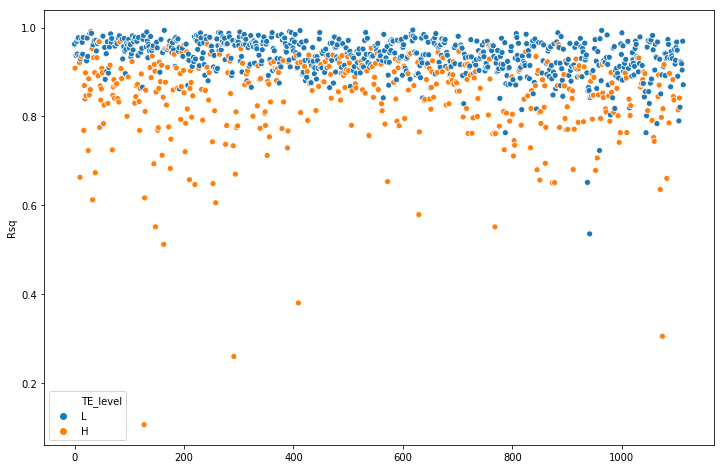

In [31]:
# Rsq and TE_level
import seaborn 

plt.figure(figsize= (12, 8))
ax= plt.subplot(111)
sns.scatterplot(data= tmp_df, y= 'Rsq', x= list(range(tmp_df.shape[0])), hue= 'TE_level' ,  ax=ax)

In [32]:
## Are the regression alpha grouped? 

## ANOVA

d= pd.DataFrame( {k: {'RegAlpha': v.UniFactorReg.params.const*12 , 
                     'IdioVol': v.UniFactorReg.resid.std()* (12**.5), 
                     'Universe': v.category, 
                     'Approach': v.approach, 
                      'TE_level': v.TE_TercileWUA, 
                     'ReportLength': v.ret.shape[0]} for k,v in {**USLC_CoreFund, 
                                                                 **USLC_GrowthFund, 
                                                                 **USLC_ValueFund}.items() }).T


# group winsorization
d_wins= []
for k,v in d.groupby( ['Universe', 'Approach', 'TE_level']): 
    
    tmp= copy.deepcopy(v)
    tmp['RegAlpha_win']= stats.mstats.winsorize(tmp['RegAlpha'], limits=[0.025, 0.025])
    tmp['IdioVol_win']= stats.mstats.winsorize( tmp['IdioVol'], limits= [0.025, 0.025])
    d_wins.append(tmp)
    
d_wins= pd.concat( d_wins, axis=0)

d= d.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)
d_wins= d_wins.apply( lambda x: pd.to_numeric( x, errors= 'ignore'), axis=1)

In [33]:
d_wins.groupby( ['Universe', 'Approach', 'TE_level']).mean() 


IdioVol  RegAlpha  ReportLength  RegAlpha_win  \
Universe    Approach TE_level                                                   
USLC_Core   F        H         0.060112  0.022907    167.803738      0.022769   
                     L         0.033878  0.006451    180.111111      0.006374   
            Q        H         0.046534  0.008895    142.750000      0.008537   
                     L         0.023836  0.003905    174.723684      0.003817   
USLC_Growth F        H         0.075936  0.024263    171.111111      0.024411   
                     L         0.049963  0.016312    185.605263      0.016411   
            Q        H         0.073067 -0.001500    150.652174     -0.001500   
                     L         0.030073  0.002175    162.513514      0.002175   
USLC_Value  F        H         0.055539  0.013692    168.153846      0.014086   
                     L         0.038688  0.010643    189.647399      0.010835   
            Q        H         0.050318  0.019793    161.870968      0.019793   
                     L         0.026630  0.009316    172.019608      0.009313   

                               IdioVol_win  
Universe    Approach TE_level               
USLC_Core   F        H            0.059919  
                     L            0.033868  
            Q        H            0.046218  
                     L            0.023721  
USLC_Growth F        H            0.075423  
                     L            0.049428  
            Q        H            0.073067  
                     L            0.030073  
USLC_Value  F        H            0.055417  
                     L            0.038702  
            Q        H            0.050318  
                     L            0.026508

In [34]:
print(sm.stats.anova_lm(ols('RegAlpha_win~ C(Approach, Sum)* C(Universe, Sum)* C(TE_level)',data= d_wins).fit(), typ=2))


                                                 sum_sq      df          F  \
C(Approach, Sum)                               0.011489     1.0  41.892047   
C(Universe, Sum)                               0.004292     2.0   7.825016   
C(TE_level)                                    0.016810     1.0  61.294356   
C(Approach, Sum):C(Universe, Sum)              0.010953     2.0  19.969092   
C(Approach, Sum):C(TE_level)                   0.001684     1.0   6.139198   
C(Universe, Sum):C(TE_level)                   0.003680     2.0   6.708781   
C(Approach, Sum):C(Universe, Sum):C(TE_level)  0.003686     2.0   6.720550   
Residual                                       0.301956  1101.0        NaN   

                                                     PR(>F)  
C(Approach, Sum)                               1.449239e-10  
C(Universe, Sum)                               4.222454e-04  
C(TE_level)                                    1.149423e-14  
C(Approach, Sum):C(Universe, Sum)              3.

### Regression Residual Dispersion

 

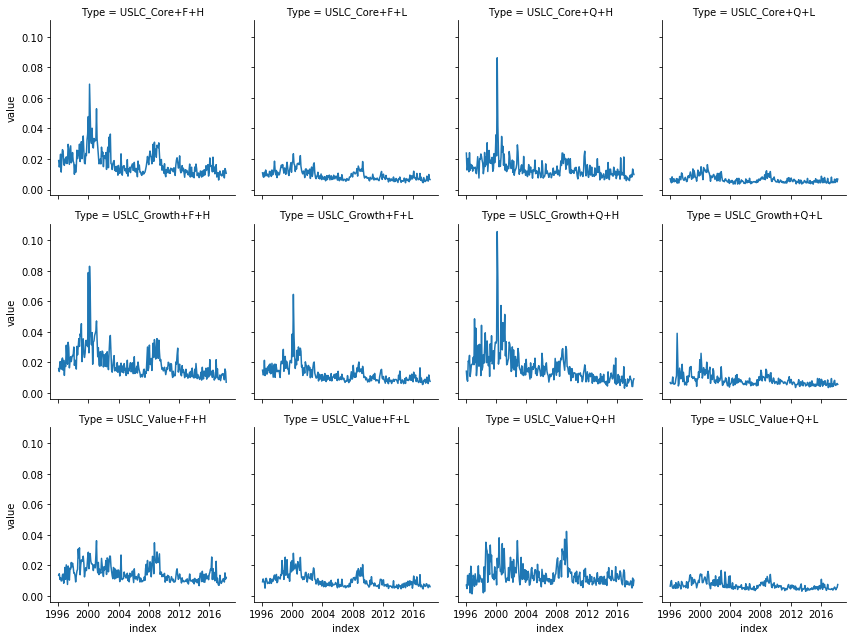

In [35]:
regResi= pd.DataFrame({k:v.UniFactorReg.resid for k,v in {**USLC_CoreFund, **USLC_GrowthFund, **USLC_ValueFund}.items() }).T

tmp_type= pd.Series( {k:v.category+'+'+v.approach+'+'+v.TE_TercileWUA for k,v in {**USLC_CoreFund, **USLC_GrowthFund, **USLC_ValueFund}.items() }, name='Type')

regResi= pd.concat( [regResi, tmp_type], axis=1)

a= pd.melt(regResi.groupby( ['Type']).std().T.reset_index(),id_vars= ['index'] )

g= sns.FacetGrid( data= a, col= 'Type', col_wrap= 4 )
g.map( plt.plot,'index' ,'value' )

### Excess Return To Benchmark Dispersion


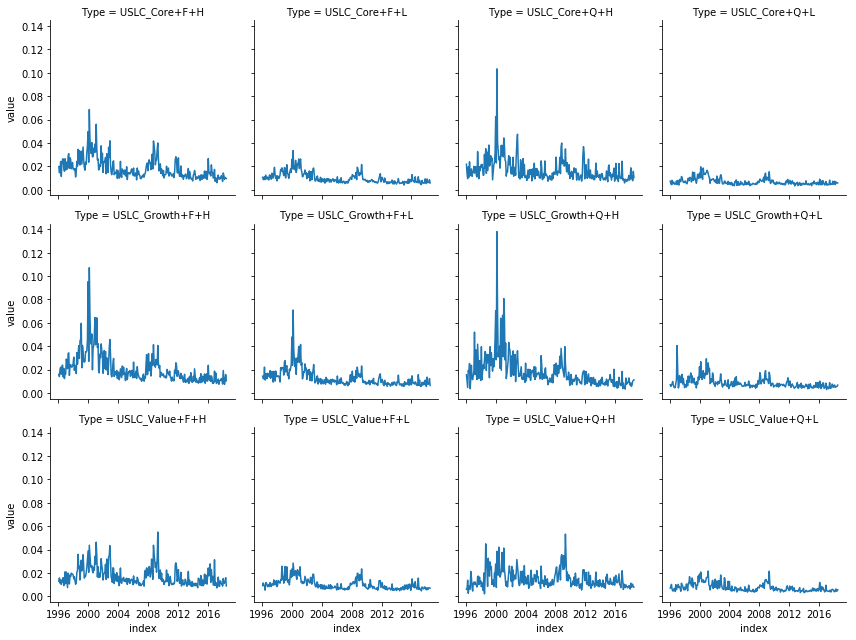

In [36]:
excRet= pd.DataFrame({k:v.ret- v.benchmark.ret for k,v in {**USLC_CoreFund, **USLC_GrowthFund, **USLC_ValueFund}.items() }).T.astype(float)

tmp_type= pd.Series( {k:v.category+'+'+v.approach+'+'+v.TE_TercileWUA for k,v in {**USLC_CoreFund, **USLC_GrowthFund, **USLC_ValueFund}.items() }, name='Type')

excRet= pd.concat( [excRet, tmp_type], axis=1)

a= pd.melt(excRet.groupby( ['Type']).std().T.reset_index(),id_vars= ['index'] )

g= sns.FacetGrid( data= a,col= 'Type', col_wrap= 4 )
g.map( plt.plot,'index' ,'value' )

### The RegAlpha can be grouped by the magnitude of average. Are they from different source? ie. how is the correlation? 




In [37]:
# regResi= pd.DataFrame({k: v.UniFactorReg.resid for k, v in {** USLC_CoreFund, ** USLC_ValueFund, **USLC_GrowthFund}.items()})

# regResi_Surv= regResi.dropna( axis=1)

In [38]:
# print(regResi.shape)
# print( regResi_Surv.shape)

In [39]:
# UniRegResi=pd.DataFrame({k:v.resid for k,v in lm_UniverseCommonFactors.items() })

# g= UniRegResi.corr().reset_index().melt(id_vars= ['index'])
# g['flag']= g['index']== g['variable']
# g= g.loc[~ g.flag].drop(columns= ['flag'])
# g['P1_Uni']= g['index'].apply(lambda x: x.split('_') [1])
# g['P1_Approach']= g['index'].apply( lambda x: x.split('_')[2])
# g['P1_TE']= g['index'].apply( lambda x: x.split('_')[3])

# g['P2_Uni']= g['variable'].apply( lambda x: x.split('_') [1])
# g['P2_Approach']= g['variable'].apply( lambda x: x.split('_')[2])
# g['P2_TE']= g['variable'].apply( lambda x: x.split('_')[3])

# g

In [40]:
# sns.heatmap(UniRegResi.corr())

### Risk/Factor Correlations

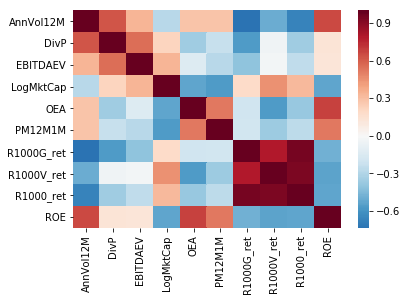

In [41]:
sysFactors= [ x for x in  Universe_CommmonFactors.values() ]
sysFactors= sorted(list(set([x for sublist in sysFactors for x in sublist])))

sysFactors_cov= df.loc[:, sysFactors].cov()* 12


sns.heatmap(df.loc[:, sysFactors].corr(), cmap= 'RdBu_r', center= 0)

### Residual Corr

 

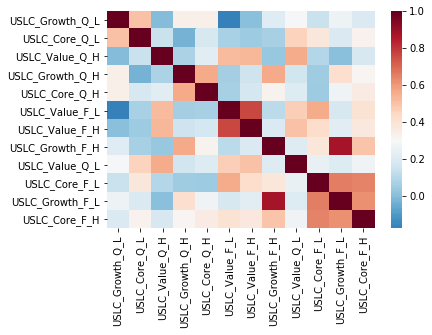

In [42]:
lm_resid= pd.DataFrame( { k:v.resid for k,v in lm_UniverseCommonFactors.items()})


sns.heatmap(lm_resid[lm_resid.corr().mean().sort_values().index].corr(), center= 0.3, cmap= 'RdBu_r')


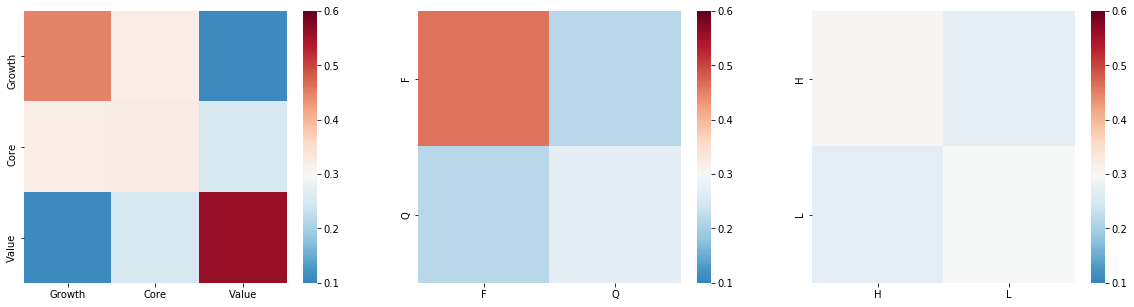

In [43]:
universe_group= {'Value': ['USLC_Value_F_H', 'USLC_Value_F_L', 'USLC_Value_Q_H', 'USLC_Value_Q_L'], 
                 'Growth': ['USLC_Growth_F_H', 'USLC_Growth_F_L', 'USLC_Growth_Q_H', 'USLC_Growth_Q_L'], 
                 'Core': ['USLC_Core_F_H', 'USLC_Core_F_L', 'USLC_Core_Q_H', 'USLC_Core_Q_L']}

approach_group= {'F': ['USLC_Core_F_H', 'USLC_Core_F_L', 'USLC_Growth_F_H', 'USLC_Growth_F_L', 'USLC_Value_F_H', 'USLC_Value_F_L'],
                  'Q': ['USLC_Core_Q_H', 'USLC_Core_Q_L', 'USLC_Growth_Q_H', 'USLC_Growth_Q_L', 'USLC_Value_Q_H', 'USLC_Value_Q_L']}


te_group = {'H': ['USLC_Core_F_H', 'USLC_Core_Q_H', 'USLC_Growth_F_H', 'USLC_Growth_Q_H', 'USLC_Value_F_H', 'USLC_Value_Q_H'] ,
            'L': ['USLC_Core_F_L', 'USLC_Core_Q_L', 'USLC_Growth_F_L', 'USLC_Growth_Q_L', 'USLC_Value_F_L', 'USLC_Value_Q_L']}

a= lm_resid.corr()
tmp= pd.DataFrame( np.diag([None]*a.shape[0]), index= a.index, columns= a.columns)

a= tmp+a


universe_corr_avg= pd.DataFrame ({k : {'Growth': a.loc[v, universe_group['Growth']].mean().mean() , 
                                       'Core': a.loc[v, universe_group['Core']].mean().mean(), 
                                       'Value': a.loc[v, universe_group['Value']].mean().mean() } for k, v in universe_group.items() })

universe_corr_avg= universe_corr_avg.loc[['Growth', 'Core', 'Value'], ['Growth', 'Core', 'Value']]


approach_corr_avg= pd.DataFrame( {k: { 'F': a.loc[v, approach_group['F']].mean().mean() , 
                                      'Q': a.loc[v, approach_group ['Q']].mean().mean() } for k,v in approach_group.items() })

approach_corr_avg= approach_corr_avg[approach_corr_avg.index]

te_corr_avg= pd.DataFrame( {k: { 'H': a.loc[v, te_group['H']].mean().mean(), 
                                 'L': a.loc[v, te_group['L']].mean().mean()} for k,v in te_group.items() })

te_corr_avg= te_corr_avg[te_corr_avg.index]


fig= plt.figure( figsize= (20, 5))
ax= plt.subplot(131)
sns.heatmap( universe_corr_avg, cmap= 'RdBu_r', center= 0.3, vmin= 0.1, vmax= 0.6, ax=ax)

ax= plt.subplot( 132)
sns.heatmap( approach_corr_avg, cmap= 'RdBu_r', center= 0.3, vmin= 0.1, vmax= 0.6, ax= ax)

ax= plt.subplot(133)
sns.heatmap( te_corr_avg, cmap= 'RdBu_r', center= 0.3, vmin= 0.1, vmax= 0.6, ax= ax)

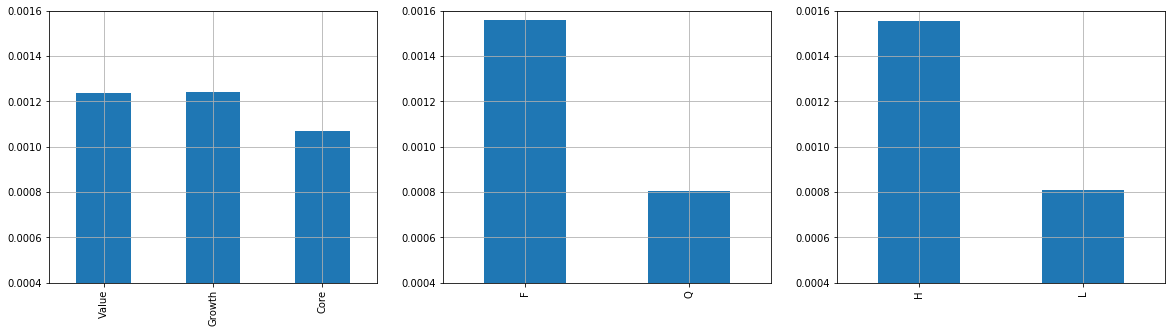

In [44]:
universe_resid_avg= pd.DataFrame ({k: lm_resid[v].mean(axis=1) for k,v in universe_group.items() } )
approach_resid_avg= pd.DataFrame ( {k: lm_resid[v].mean(axis=1) for k,v in approach_group.items() })
te_resid_avg= pd.DataFrame( { k: lm_resid[v].mean( axis=1) for k,v in te_group.items() })

fig= plt.figure( figsize=( 20, 5))
ax= plt.subplot(131)
universe_resid_avg.mean().plot.bar(ax= ax, ylim= [4/10000, 16/10000])
ax.grid()

ax= plt.subplot( 132)
approach_resid_avg.mean().plot.bar(ax= ax, ylim= [4/10000, 16/10000])
ax.grid()

ax= plt.subplot(133)
te_resid_avg.mean().plot.bar(ax =ax, ylim= [4/10000, 16/10000])
ax.grid()

### 50% R1000V+ 50% R1000G Vs. 100% R1000

In [45]:
bm_ret= pd.DataFrame({k:v.ret for k,v in BM_Index.items()})

bm_ret['V+G']= (bm_ret.R1000G+ bm_ret.R1000V)/2

bm_val= (bm_ret+1).rolling( window= bm_ret.shape[0]+10, min_periods=1).apply( lambda x: x.prod(axis=0))

C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


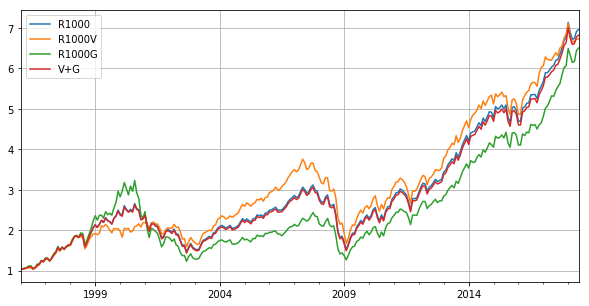

In [46]:
bm_val.plot(figsize= (10, 5))

plt.grid()
plt.savefig( 'R1000_accvalue.jpg')

In [47]:
## Overall speaking, R1000 can be replicated by 50% V and 50% G


### Integer Programming (by CVXPY)


Depending on the investor's preference (about style, approach and managers' tracking error profile), one may have different opportunity sets for portfolio manager allocation over all categories. Remember that with current dimension settings (style, approach and tracking error), we have $P=12$ categories defined by $Q=3$ dimensions.  

We use IP to explore the opportunity sets corresponding to investor's preference. 

**Integer Optimization**

$$ Min_{\theta} \space f(\theta)$$

subject to: 
$\theta \in N^{P}\\
\theta \geq 0 \\
\theta^{T} e= k \\
$

control condition: 
$c_i \leq g(\theta) \leq c_{i+1}$


$k$ is the number of managers the investor will allocate. The control condition is optional for this optimization problem. It controls the feasible region. By tunning the control condition one can exhaust all the optimal solutions. $e$ is a vector with all element equal to 1. 


We set the objective function $f: N^{P} \rightarrow R$

$$
f(\theta) = (h(\theta)- y^*)^{T}\Omega \space (h(\theta)- y^*)+ \lambda s(\theta) \\
h(\theta) = F \space \frac {\theta}{\theta^T e}= F \space \frac {\theta}{k} 
$$

$h: N^{P} \rightarrow R^Q $ maps the manager allocation to the portfolio exposure over three dimensions, while $y^*$ is the desired dimension exposure by investor. $F$ is a $Q x P$ matrix and each column records the dimension exposure of managers in each category. $f$ does not penalize deviation equivalently over all dimensions. The weight is defined by $\Omega$, a $Q x Q$ semi positive definite matrix

The concentration over few category is also penalized. $s$ measures the imbalance of the manager allocation cross categories. The difference of mean square and square of mean (i.e. variance) is used as a proxy.  

`Note: We set relatively small concentration penalty multiplier lambda to focus on the deviation penalty`

*Control Condition*

The feasible region is defined by $\{c_i\}$ and distance function $g: R^P \rightarrow R$

$$
g(\theta)= u^T\space \theta
$$

$u$ is a weight vector with positive and non-identical entries. 


`Note: We define non-identical weight to differentiate between optimal solutions.`



More exactly, we set

+ $k= 2, 3, ..., 12, 15, 18, 21, 24, 27$
+ $P=12, Q=3$
+ $\lambda = \frac 1{ k+1}$
+ $\Omega=  diag(12, 2, 5) $      (12 for style, 2 for approach, 5 for tracking error profile)
+ $u= sqrt([1, \frac{P-1}{P}, \frac{P-2}{P}, ..., \frac{1}{P}])$ 

+ $\{c_{i, i=0,1,...L} \}$ between $a, b$ 
    + with current setting, $a= \frac1{P}k$, $b= k$
    + $c_i= a+ \frac{i}{L} (b-a), i=0,1,...,L$
    + $L=200$

In [48]:
import cvxpy as cp
import math

P= 12
Q= 3
k_list= [i for i in range(2,23, 1)] + [ 24, 27, 30, 33, 36]
L= 200
u_condit= np.array( [(1-i/P)**(0.5) for i in range( 0,P,1)])
Omega= pd.DataFrame( np.diag([12, 2,5]), index= ['style', 'approach', 'te'], columns=['style', 'approach', 'te'] )
F= pd.DataFrame([[x,y,z] for x in [-1,0,1] for y in [-1,1] for z in [-1,1]], columns= ['style', 'approach', 'te'])
F.index= F.apply( lambda x: '_'.join([str(t) for t in x]), axis=1)
F= F.T
target_exp= np.zeros( Q)


# # Optimum overall feasible regions and exhaustive search
# k_optimum= {}
# k_optsearch= {}

# for k in k_list: 
#     theta= cp.Variable( P, integer= True)
#     lam= ((k+1)** -1) 
#     opt_objective= cp.quad_form( F.values* theta/k- target_exp, Omega.values)+ lam* (cp.sum_squares(theta)/P- k**2/ P**2)
#     cnstr1= theta>=0
#     cnstr2= cp.sum(theta)==k
#     opt_problem= cp.Problem( cp.Minimize( opt_objective), constraints=[cnstr1, cnstr2])
#     opt_result= opt_problem.solve( solver= cp.ECOS_BB, verbose= False, 
#                                   mi_max_iters= 100000, mi_abs_eps= 1e-12* k**-2, mi_rel_eps= 1e-8* k**-2)
#     print(k)
#     print(opt_problem.status)
#     penalty_concentration= lam* ((np.array(theta.value).flatten()**2).sum()/P- k**2/P**2) 
#     penalty_deviation= opt_result- penalty_concentration
    
#     if opt_problem.status== 'optimal': 
#         k_optimum[k]= {'optimum': pd.Series(np.round(theta.value, decimals= 2).flatten(), index= F.columns), 
#                        'penalty_deviation': penalty_deviation, 
#                        'penalty_concentration': penalty_concentration, 
#                        'opt_problem': opt_problem, 
#                        'lam': lam }
    
#     # exhaustive search
#     a= np.min(u_condit)* k
#     b= np.max(u_condit)* k
#     d= (a+b)/2.001
#     log_base= 2
#     log_a= math.log( a, log_base)
#     log_b= math.log( b, log_base)
#     log_d= math.log( d, log_base)
#     second_half_num= int(L/2)+1
#     c_list_second= np.logspace( start= log_d, stop= log_b, base= log_base, num= second_half_num)
#     c_list_first= c_list_second* -1+ 2*d
#     c_list= np.concatenate( (c_list_first, c_list_second))
#     c_list= np.unique( np.sort(c_list) )
    
#     optsearch= {}

#     for i in range(0, L-1, 1): 
#         theta= cp.Variable(P, integer= True)
#         cnstr1= theta>=0 
#         cnstr2= cp.sum(theta)==k
#         cnstr3= theta.T* u_condit >= c_list[i]
#         cnstr4= theta.T* u_condit <= c_list[i+1]
#         opt_objective= cp.quad_form( F.values* theta/k- target_exp, Omega.values)+ lam* (cp.sum_squares(theta)/P- k**2/ P**2)
#         opt_condit= cp.Problem( cp.Minimize( opt_objective), 
#                                 constraints= [cnstr1, cnstr2, cnstr3, cnstr4 ] )
#         opt_condit_result= opt_condit.solve( solver = cp.ECOS_BB, verbose= False,
#                                             mi_max_iters= 10000, mi_abs_eps= 1e-18* k**-2, mi_rel_eps= 1e-10* k**-2)
#         if opt_condit.status != 'optimal': 
#             print('       '+str(i)+ ':'+opt_condit.status )
#         else:
#             print('   '+str(i)+ ':'+opt_condit.status )
            
#             tmp_p= lam* ((np.array(theta.value).flatten()**2).sum()/P- k**2/P**2) 
#             optsearch[i]= {'optimum': pd.Series(np.round(theta.value, decimals= 2).flatten(), index= F.columns), 
#                              'opt_problem': opt_condit,
#                              'lam': lam,
#                              'penalty_concentration': tmp_p, 
#                              'penalty_deviation': opt_condit_result- tmp_p,
#                              'control_low': c_list[i],
#                              'control_up': c_list[i+1],
#                              'k':k}
            
#     k_optsearch[k]= optsearch
    
            
# pickle.dump( k_optimum, open( 'k_optimum.p', 'wb'))
# pickle.dump( k_optsearch, open( 'k_optsearch.p', 'wb'))


k_optimum= pickle.load( open( 'k_optimum.p', 'rb'))
k_optsearch= pickle.load( open( 'k_optsearch.p', 'rb'))

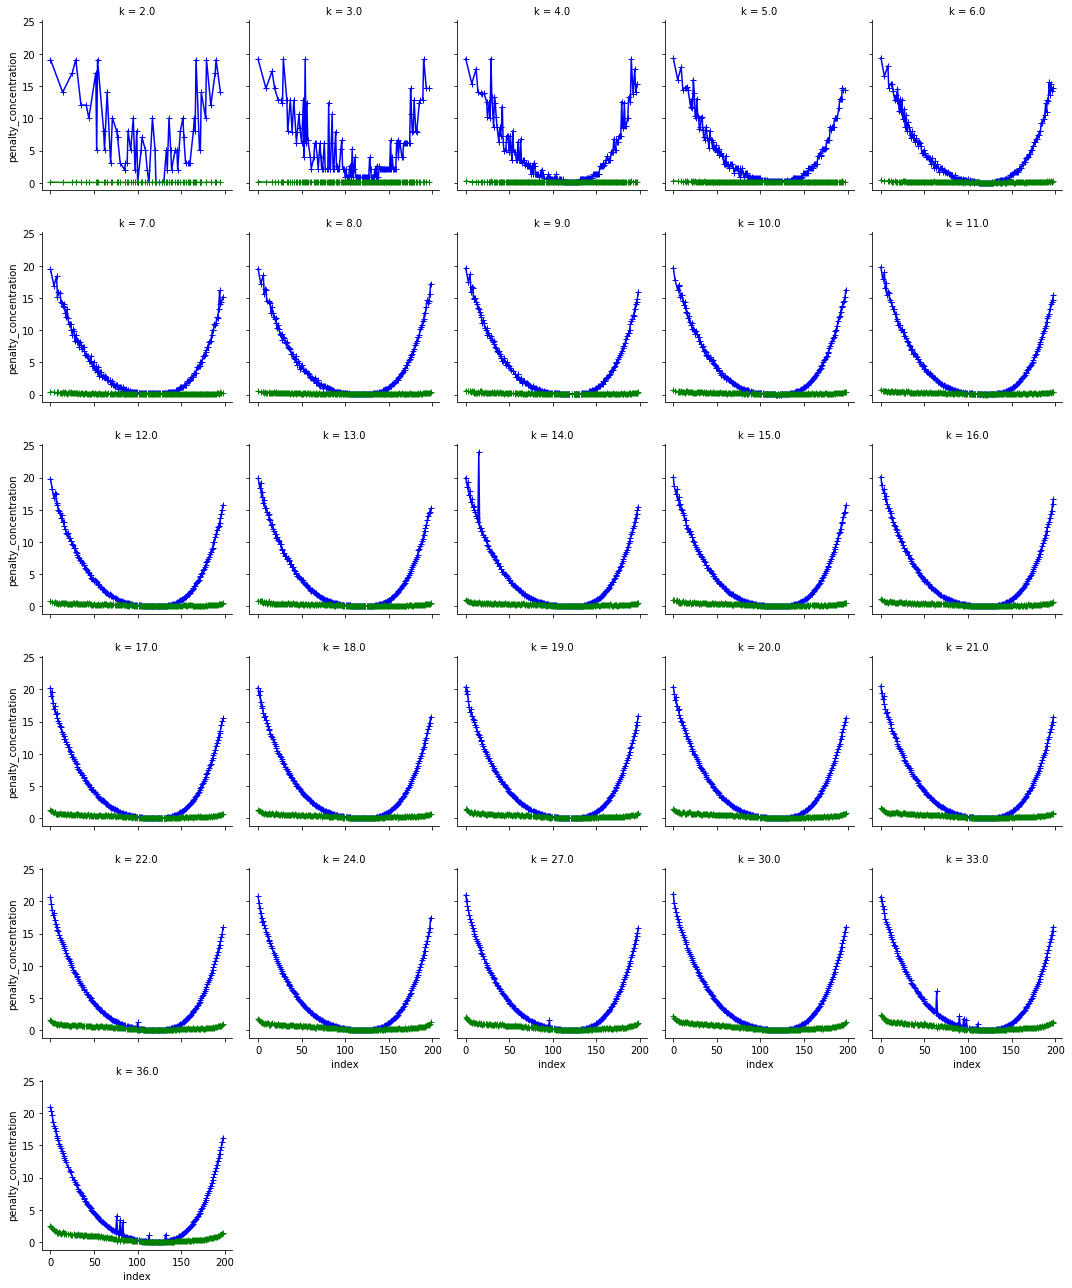

In [62]:
# visualization

opt_search_summary= []
for k in k_list: 
    tmp_df= pd.DataFrame({s: {'obj_value': t['opt_problem'].value,
                              'penalty_concentration': t['penalty_concentration'], 
                              'k': k} for s,t in k_optsearch[k].items() } ).T
    # kickout outliers... 
    a= tmp_df.obj_value<100
    tmp_df= tmp_df.loc[a, ]        
    
    opt_search_summary.append( tmp_df)
    


opt_search_summary= pd.concat( opt_search_summary, axis=0, )
# opt_search_summary= opt_search_summary.loc[opt_search_summary.k==3, ]
# opt_search_summary= opt_search_summary.loc[np.logical_and( opt_search_summary.index>= 90, 
#                                                           opt_search_summary.index<= 130), ]
opt_search_summary.reset_index( drop=False, inplace= True)

g= sns.FacetGrid( data= opt_search_summary, col= 'k', col_wrap= 5, )
g.map( plt.plot, 'index', 'obj_value', marker= '+', color= 'blue')
g.map( plt.plot, 'index', 'penalty_concentration', marker= '+', color= 'green', )

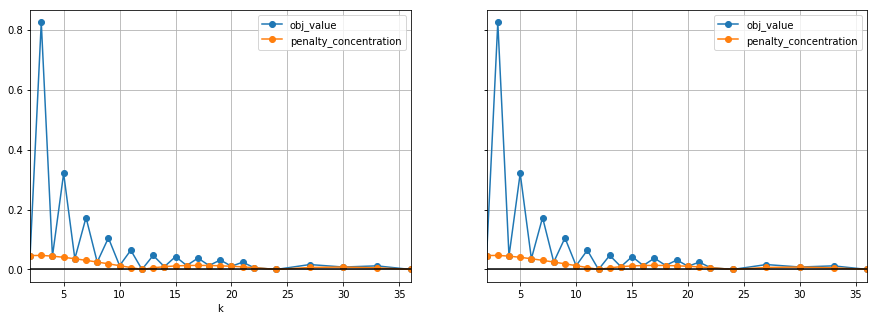

In [63]:

f, (ax1, ax2)= plt.subplots(1,2, sharey=True, figsize= ( 15, 5))
opt_search_summary.groupby(['k']).min().drop(columns= ['index']).plot(marker= 'o', ax= ax1)
ax1.axhline(0,c= 'black')
ax1.grid()

opt_global_summary= pd.DataFrame( {k: {'obj_value': v['opt_problem'].value, 
                                      #  'penalty_deviation': v['penalty_deviation'], 
                                       'penalty_concentration': v['penalty_concentration']} for k,v in k_optimum.items()}).T

opt_global_summary.plot(marker= 'o', ax= ax2)
ax2.axhline(0, c='black')
ax2.grid()

In [66]:
opt_search_summary.loc[opt_search_summary.k==36, 'obj_value'].sort_values().reset_index(drop=True).head(30)

0     5.961147e-10
1     9.008719e-03
2     9.008797e-03
3     9.009008e-03
4     1.067734e-02
5     1.376360e-02
6     1.376374e-02
7     1.376376e-02
8     1.993641e-02
9     1.993656e-02
10    2.894506e-02
11    2.894557e-02
12    3.795462e-02
13    3.795462e-02
14    5.146792e-02
15    6.573240e-02
16    6.573240e-02
17    7.924510e-02
18    7.924591e-02
19    9.275943e-02
20    9.776443e-02
21    1.112779e-01
22    1.345512e-01
23    1.435602e-01
24    1.525692e-01
25    1.620777e-01
26    1.710878e-01
27    1.910244e-01
28    1.936103e-01
29    2.135469e-01
Name: obj_value, dtype: float64

In [67]:
a= opt_search_summary.groupby( ['k']).min(axis=0).drop(columns= ['index', 'penalty_concentration'])
a.columns= ['optsearch_obj_value']

a= pd.concat( [a, opt_global_summary], axis=1).round(decimals= 5).astype(float)
a['global_opt_effective']= (a.obj_value- a.optsearch_obj_value)<= 1e-5

a

,optsearch_obj_value,obj_value,penalty_concentration,global_opt_effective
2.0,0.04629,0.04630,0.04630,False
3.0,0.82465,0.82439,0.04687,True
4.0,0.04444,0.04444,0.04444,True
5.0,0.32050,0.32051,0.04051,False
6.0,0.03571,0.03571,0.03571,True
7.0,0.17322,0.17324,0.03038,False
8.0,0.02469,0.02469,0.02469,True
9.0,0.10517,0.10517,0.01875,True
10.0,0.01263,0.01263,0.01263,True
11.0,0.06422,0.06422,0.00637,True


2
Int64Index([100, 113, 121, 125, 128, 130], dtype='int64')
3
Int64Index([100, 102, 103, 104, 107, 109, 112, 113, 114, 115, 116, 117, 119,
            120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 132, 133, 135,
            138,  -1],
           dtype='int64')
4
Int64Index([106, 110, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125,
            126, 127, 128, 129],
           dtype='int64')
5
Int64Index([106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
            120, 121, 122, 124, 125, 127, 128, 129, 130, 132, 133, 134,  -1],
           dtype='int64')
6
Int64Index([112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
            126, 127, 129,  -1],
           dtype='int64')
7
Int64Index([112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125,
            126, 128, 129, 130,  -1],
           dtype='int64')
8
Int64Index([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126], dtype='int64')
9
Int64Index([114, 115, 116, 117, 118, 119, 122,

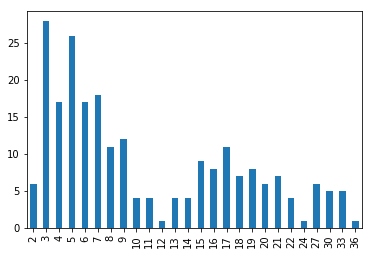

In [68]:
D3_opposet= {} # the opportunity set for each k when investor optimize over 3 dimensions

opt_value_abstol= 1e-4
opt_value_reltol= 0.1

for k in k_list: 
    opt_value= pd.Series({x: v['opt_problem'].value for x, v in k_optsearch[k].items() }, name= 'obj_value')
    # loosen the optimal value by both absolute and relative 
    a1=  opt_value.min()+ opt_value_abstol
    a2=  np.absolute(opt_value.min()) * (1+ opt_value_reltol) # take absolute value if the optimal value touches the negative territory due to numerical reason
    opt_value_min= min(a1, a2)
    optimum_index= list(opt_value.loc[opt_value<= opt_value_min].index)
    optimum= pd.concat( [pd.Series(k_optsearch[k][x]['optimum'], name= x) for x in optimum_index], axis=1).astype(int)
    
    global_opt_value= k_optimum[k]['opt_problem'].value
    if max(global_opt_value+ opt_value_abstol, 
           np.absolute( global_opt_value)* (1+ opt_value_reltol))<= np.absolute( opt_value.min()):
        # global optimum dominates
        optimum= pd.DataFrame( k_optimum[k]['optimum'].astype(int), columns= [-1])
        
    elif global_opt_value <= opt_value_min: 
        optimum[-1]=  k_optimum[k]['optimum'].astype(int) # encode the name of solution from global optimization by -1
    
    
    optimum= optimum.T.drop_duplicates().T
    
    print(k)
    print( optimum.columns)
    
    D3_opposet[k]= optimum
    
    
# opt_global_optimum= pd.DataFrame({k: k_optimum[k]['optimum'] for k in k_optimum.keys() }).astype(int)
    


pd.Series({k:v.shape[1] for k,v in D3_opposet.items() }).plot.bar()

#### `D1_Opposet`

We calculate the opportunity set one investor face when he/she optimize over 3 dimensions (style, approach and tracking error profile). Similarly, we can compute the opportunity set for investors who consider only style dimension. 




Similarly, 

$$ Min_{\theta} \space l(\theta)$$

subject to: 
$\theta \in N^{P}\\
\theta \geq 0 \\
\theta^{T} e= k \\
$

control condition: 
$c_i \leq g(\theta) \leq c_{i+1}$


We set the objective function $l: N^{P} \rightarrow R$

$$
l(\theta) =\eta (\frac {z^T \theta} {k}- y_s^*)^2 \space + \lambda s(\theta) 
$$

$y_s^*$ is the desired style exposure by investor. The concentration over few category is also penalized. $s$ measures the imbalance of the manager allocation cross categories. The difference of mean square and square of mean (i.e. variance) is used as a proxy.  

`Note: We set relatively small concentration penalty multiplier lambda to focus on the deviation penalty`

*Control Condition*

The feasible region is defined by $\{c_i\}$ and  function $g: R^P \rightarrow R$

$$
g(\theta)= u^T\space \theta
$$

$u$ is a weight vector with positive and non-identical entries. 


`Note: We define non-identical weight to differentiate between optimal solutions.`



More exactly, we set

+ $k= 2, 3, ..., 12, 15, 18, 21, 24, 27$
+ $P=3$
+ $\lambda = \frac 1{ k+1}$
+ $\eta= 10$
+ $u= sqrt([1, \frac{P-1}{P}, \frac{P-2}{P}, ..., \frac{1}{P}])$ 
+ $\{c_{i, i=0,1,...L} \}$ between $a, b$ 
    + with current setting, $a= min(c_i)k$, $b= max(c_i) k$
    + $c_i= a+ \frac{i}{L} (b-a), i=0,1,...,L$
    + $L=200$

In [69]:


P=3
z= pd.Series( {-1: -1, 0:0, 1:1}, name= 'style')
k_list= [i for i in range(2,23, 1)] + [ 24, 27, 30, 33, 36]
L= 200
u_condit= np.array( [(1-i/P)**(0.5) for i in range( 0,P,1)])
target_style_exp=0

k_optsearch_D1= {}

# for k in k_list: 
    
#     lam= ((k+1)** -1)
#     # exhaustive search
#     a= np.min(u_condit)* k
#     b= np.max(u_condit)* k
#     d= (a+b)/2.001
#     log_base= 2
#     log_a= math.log( a, log_base)
#     log_b= math.log( b, log_base)
#     log_d= math.log( d, log_base)
#     second_half_num= int(L/2)+1
#     c_list_second= np.logspace( start= log_d, stop= log_b, base= log_base, num= second_half_num)
#     c_list_first= c_list_second* -1+ 2*d
#     c_list= np.concatenate( (c_list_first, c_list_second))
#     c_list= np.unique( np.sort(c_list) )
    
#     optsearch= {}
#     print(k)
#     for i in range(0, L-1, 1): 
#         theta= cp.Variable(P, integer= True)
#         cnstr1= theta>=0 
#         cnstr2= cp.sum(theta)==k
#         cnstr3= theta.T* u_condit >= c_list[i]
#         cnstr4= theta.T* u_condit <= c_list[i+1]
#         opt_objective= 10* ( z.values* theta/k- target_style_exp)**2 + lam* (cp.sum_squares(theta)/P- k**2/ P**2)
#         opt_condit= cp.Problem( cp.Minimize( opt_objective), 
#                                 constraints= [cnstr1, cnstr2, cnstr3, cnstr4 ] )
#         opt_condit_result= opt_condit.solve( solver = cp.ECOS_BB, verbose= False,
#                                             mi_max_iters= 1000, mi_abs_eps= 1e-18* k**-2, mi_rel_eps= 1e-10* k**-2)
#         if opt_condit.status != 'optimal': 
#             print('       '+str(i)+ ':'+opt_condit.status )
#         else:
#             print('   '+str(i)+ ':'+opt_condit.status )
            
#             tmp_p= lam* ((np.array(theta.value).flatten()**2).sum()/P- k**2/P**2) 
#             optsearch[i]= {'optimum': pd.Series(np.round(theta.value, decimals= 2).flatten(), index= z.index), 
#                              'opt_problem': opt_condit,
#                              'lam': lam,
#                              'penalty_concentration': tmp_p, 
#                              'penalty_deviation': opt_condit_result- tmp_p,
#                              'control_low': c_list[i],
#                              'control_up': c_list[i+1],
#                              'k':k}
            
#     k_optsearch_D1[k]= optsearch
    
            
# pickle.dump( k_optsearch_D1, open( 'k_optsearch_D1.p', 'wb'))


k_optsearch_D1= pickle.load( open( 'k_optsearch_D1.p', 'rb'))
    
    
        




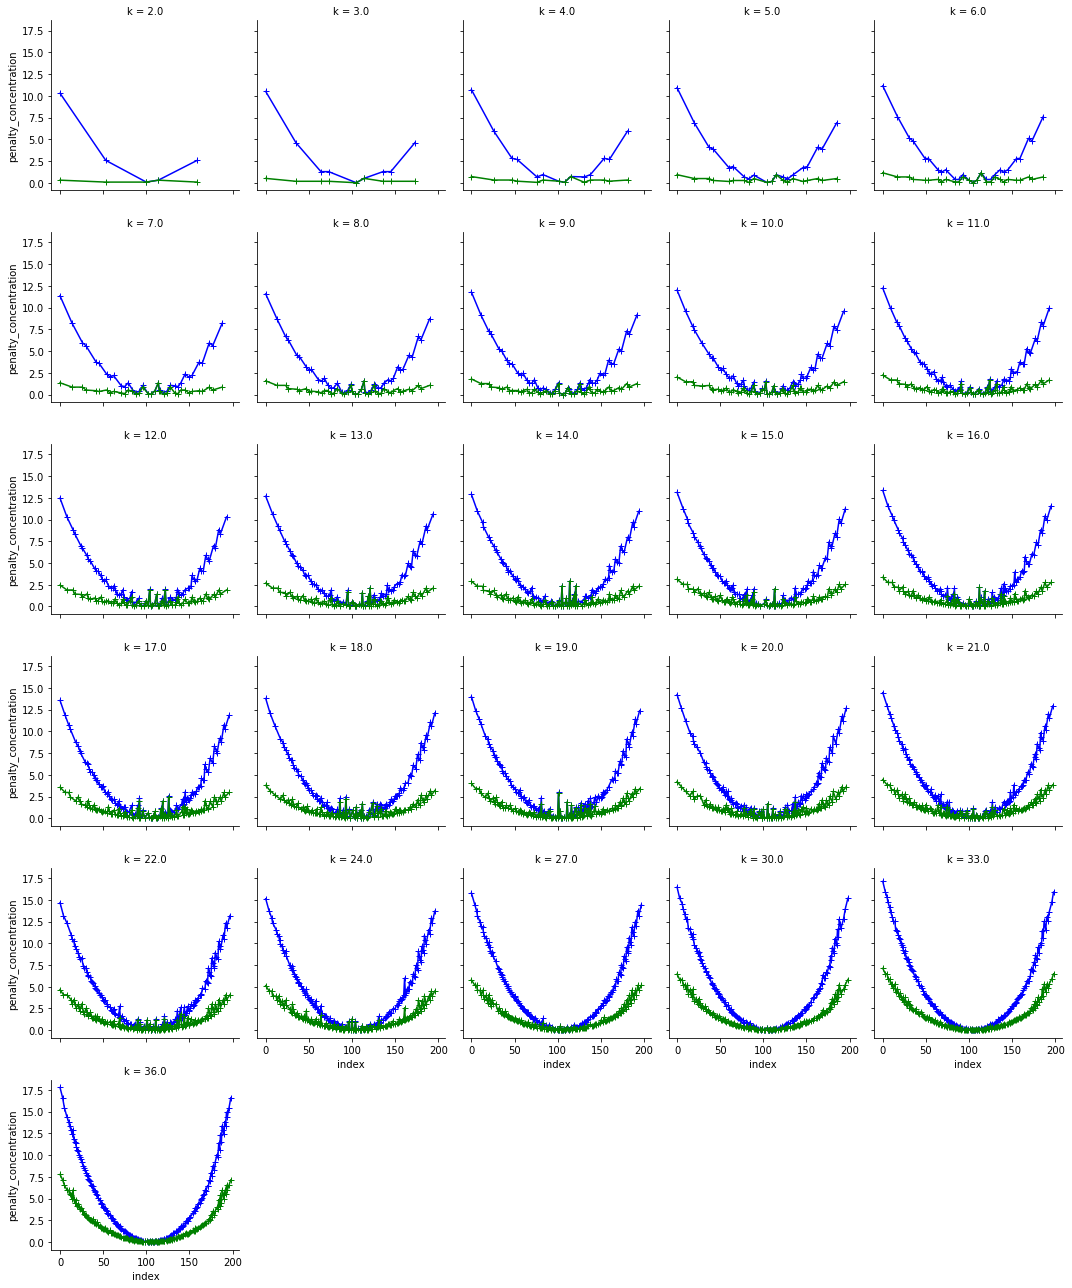

In [70]:
# visualization

opt_search_summary= []
for k in k_list: 
    tmp_df= pd.DataFrame({s: {'obj_value': t['opt_problem'].value,
                              'penalty_concentration': t['penalty_concentration'], 
                              'k': k} for s,t in k_optsearch_D1[k].items() } ).T
    # kickout outliers... 
    a= tmp_df.obj_value< 100
    tmp_df= tmp_df.loc[a, ]        
    
    opt_search_summary.append( tmp_df)
    


opt_search_summary= pd.concat( opt_search_summary, axis=0, )
# opt_search_summary= opt_search_summary.loc[opt_search_summary.k==3, ]
# opt_search_summary= opt_search_summary.loc[np.logical_and( opt_search_summary.index>= 85, 
#                                                           opt_search_summary.index<= 120), ]
opt_search_summary.reset_index( drop=False, inplace= True)

g= sns.FacetGrid( data= opt_search_summary, col= 'k', col_wrap= 5, )
g.map( plt.plot, 'index', 'obj_value', marker= '+', color= 'blue')
g.map( plt.plot, 'index', 'penalty_concentration', marker= '+', color= 'green', )

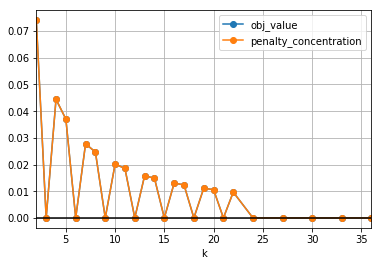

In [71]:


opt_search_summary.groupby(['k']).min().drop(columns= ['index']).plot(marker= 'o',)
plt.axhline(0,c= 'black')
plt.grid()


2
Int64Index([100], dtype='int64')
3
Int64Index([105], dtype='int64')
4
Int64Index([108], dtype='int64')
5
Int64Index([104], dtype='int64')
6
Int64Index([105], dtype='int64')
7
Int64Index([106], dtype='int64')
8
Int64Index([103], dtype='int64')
9
Int64Index([106], dtype='int64')
10
Int64Index([107], dtype='int64')
11
Int64Index([105], dtype='int64')
12
Int64Index([105], dtype='int64')
13
Int64Index([105], dtype='int64')
14
Int64Index([104], dtype='int64')
15
Int64Index([106], dtype='int64')
16
Int64Index([105], dtype='int64')
17
Int64Index([105], dtype='int64')
18
Int64Index([106], dtype='int64')
19
Int64Index([105], dtype='int64')
20
Int64Index([104], dtype='int64')
21
Int64Index([106], dtype='int64')
22
Int64Index([106], dtype='int64')
24
Int64Index([105], dtype='int64')
27
Int64Index([105], dtype='int64')
30
Int64Index([106], dtype='int64')
33
Int64Index([106], dtype='int64')
36
Int64Index([106], dtype='int64')


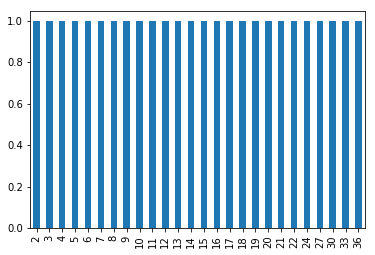

In [72]:
D1_opposet= {} # the opportunity set for each k when investor optimize over style dimension

opt_value_abstol= 1e-4
opt_value_reltol= 0.5

for k in k_list: 
    opt_value= pd.Series({x: v['opt_problem'].value for x, v in k_optsearch_D1[k].items() }, name= 'obj_value')
    # loosen the optimal value by both absolute and relative 
    a1=  opt_value.min()+ opt_value_abstol
    a2=  np.absolute(opt_value.min()) * (1+ opt_value_reltol) # take absolute value if the optimal value touches the negative territory due to numerical reason
    opt_value_min= min(a1, a2)
    optimum_index= list(opt_value.loc[opt_value<= opt_value_min].index)
    optimum= pd.concat( [pd.Series(k_optsearch_D1[k][x]['optimum'], name= x) for x in optimum_index], axis=1).astype(int)    
    
    optimum= optimum.T.drop_duplicates().T
    
    print(k)
    print( optimum.columns)
    
    D1_opposet[k]= optimum
    
    
# opt_global_optimum= pd.DataFrame({k: k_optimum[k]['optimum'] for k in k_optimum.keys() }).astype(int)
    


pd.Series({k:v.shape[1] for k,v in D1_opposet.items() }).plot.bar()

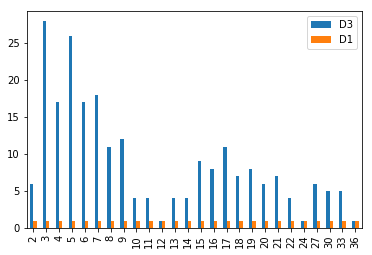

In [73]:
pd.concat([pd.DataFrame({k: {'D3':v.shape[1]} for k,v in D3_opposet.items()}).T, 
           pd.DataFrame({k: {'D1': v.shape[1]} for k,v in D1_opposet.items()}).T], axis=1).plot.bar()

In [74]:
{k: v.max().max() for k,v in D3_opposet.items()}

{2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 24: 2,
 27: 3,
 30: 3,
 33: 3,
 36: 3}

In [75]:
# Transform opporset to better form 

D3_opposet_scheme= {}
for k, df in D3_opposet.items(): 
    scheme_list= []
    mgr_code= ['PM_'+ str(i) for i in range( 1, k+1,1)]
    exposure_dict= pd.DataFrame( [[int(x) for x in u.split('_')] for u in df.index], index= df.index, columns= ['style', 'approach', 'te']).T.to_dict()

    for col in df.columns: 
        t= df[col]
        t= t[t>0].to_dict()
        mgr_list= []
        for l,s in t.items():
            mgr_list= mgr_list+  [l]*s
        mgr_dict= {mgr_code[i]: exposure_dict[mgr_list[i]] for i in range(len(mgr_code))}
        scheme_list.append( pd.DataFrame( mgr_dict))
    
    D3_opposet_scheme[k]= scheme_list
        
        
D1_opposet_scheme= {}
for k, df in D1_opposet.items(): 
    scheme_list= []
    mgr_code= ['PM_'+ str(i) for i in range( 1, k+1, 1)]
    exposure_dict= pd.DataFrame( [[u] for u in df.index], index= df.index, columns= ['style']).T.to_dict()
    
    for col in df.columns: 
        t= df[col]
        t= t[t>0].to_dict()
        mgr_list= []
        for l,s in t.items():
            mgr_list= mgr_list+ [l]*s
        mgr_dict= {mgr_code[i]: exposure_dict[ mgr_list[i]] for i in range(len(mgr_code))}
        scheme_list.append( pd.DataFrame( mgr_dict))
        
    D1_opposet_scheme[k]= scheme_list
    

By incorporating two new dimensions (Approach and Active Risk) we have shrinked the opportunity set the investor faces significantly. 

    - Imagine an investor who has Dim1 constrain will have opportunity set {Growth: 1, Core: 2, Value:1}  
    
    - We believe there are other dimensions determing the portfolio active performance. From a Dim3 perspective, this investor actually has a wild opportunity set consisting of 4^1 x 4^2 x 4^1 allocations. 
    
For a comprehensive comparation

In [76]:
D3_opposet_schemecount= pd.Series( {k: len(v) for k,v in D3_opposet_scheme.items() }, name= 'D3_oppocount')
D1_opposet_scehmecount= pd.Series( {k: len(v) * 4**k for k,v in D1_opposet_scheme.items() }, name= 'D1_oppocount')

pd.concat( [D3_opposet_schemecount, D1_opposet_scehmecount], axis=1)

,D3_oppocount,D1_oppocount
2,6,16
3,28,64
4,17,256
5,26,1024
6,17,4096
7,18,16384
8,11,65536
9,12,262144
10,4,1048576
11,4,4194304


In [77]:
D3_opposet[4]

,106,110,113,114,115,116,117,119,120,121,123,124,125,126,127,128,129
-1_-1_-1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
-1_-1_1,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0
-1_1_-1,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0
-1_1_1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0
0_-1_-1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1
0_-1_1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1
0_1_-1,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,1
0_1_1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1
1_-1_-1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0
1_-1_1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0


In [78]:
D3_opposet[9]

,114,115,116,117,118,119,122,124,125,126,127,-1
-1_-1_-1,1,1,1,0,0,1,1,1,0,1,0,1
-1_-1_1,1,1,1,1,1,1,0,1,1,0,1,0
-1_1_-1,1,1,0,1,1,1,1,0,1,1,1,1
-1_1_1,1,0,1,1,1,1,1,1,1,1,1,1
0_-1_-1,0,0,0,1,1,0,0,0,1,1,1,1
0_-1_1,0,1,1,1,0,1,1,1,1,1,1,1
0_1_-1,0,1,1,1,1,0,1,1,0,0,1,0
0_1_1,1,1,1,0,1,0,1,1,1,1,0,1
1_-1_-1,1,0,1,0,1,1,1,1,1,1,1,0
1_-1_1,1,1,0,1,1,1,1,1,1,1,1,1


In [79]:
# import importlib
# import cio_portfolio
# importlib.reload( cio_portfolio)
# from cio_portfolio import manager_selector

# pm_picker= manager_selector( selection_skill= 0, selection_survival= False, manager_dimension_scheme= D3_opposet_scheme)
# d1= datetime.datetime( 1996, 1,31)
# d2= datetime.datetime( 1999,1,1)
# pm_pool= list(AllManager_return.loc[d1, ].dropna().index)
# cur_mg, mg_exp= pm_picker.initial_select( PM_pool= pm_pool,
#                          PM_returns=AllManager_return, 
#                          fwdperiod_start= d1, fwdperiod_end= d2, PM_Info= AllManager_Info, 
#                          manager_weight_allocation= {'PM_1':1/4, 'PM_2': 1/4, 'PM_3': 1/4, 'PM_4':1/4})

# cur_mg_drop= copy.deepcopy(cur_mg)
# cur_mg_drop['PM_4']= None

# pm_picker.second_select(PM_pool= pm_pool, 
#                         PM_returns=AllManager_return, 
#                         PM_Info=AllManager_Info, 
#                         fwdperiod_start= d1, 
#                         fwdperiod_end= d2, 
#                         manager_dimension_allocation= mg_exp, 
#                         cur_manager= cur_mg_drop)



#### Wrap the Allocation Solver



## Investor Portfolio Construction: Structure Blind Vs. Diversification over Dimensions

The USLC equity managers can be grouped by Universe (C/V/G), Approach (F/Q), Tracking Error (H/L). People usually notice the structure of Universe. Given a number (N) of managers to invest, does diversification over dimensions (**i.e. construct investment portfolio based on structure not only style, but in other perspectives (Approach & TE level)** ) generate some benefit? 



https://faculty.mccombs.utexas.edu/keith.brown/Research/portconcentrate-wp.pdf




#### Manager Selection Skill

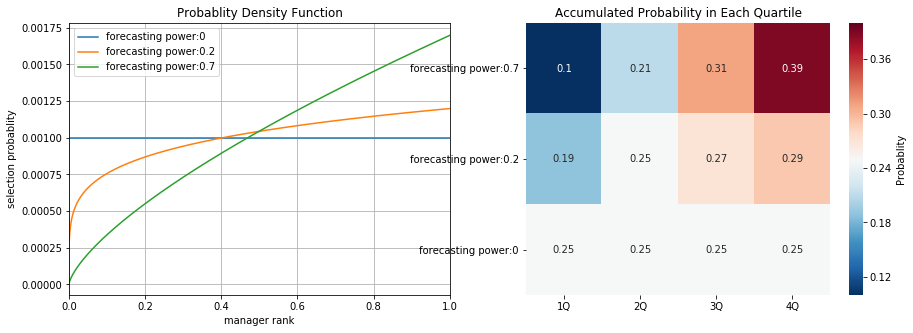

In [80]:
plt.figure(figsize=( 15, 5))


ax= plt.subplot(121)
t= pd.Series([i/1000 for i in range(1, 1001)])
t= pd.DataFrame({'manager rank': t, 
                 # 'v:-0.1': t**(-0.1),
                 'forecasting power:0': t**0, 
                 # 'fp:0.1': t**0.1, 
                 'forecasting power:0.2': t**0.2, 
               #   'v:0.5': t**0.3, 
                 #  'fp:0.7': t**0.7, 
                  'forecasting power:0.7': t** 0.7, 
                }) 
t.set_index( 'manager rank', drop=True, inplace=True)
t= t.div( t.sum(), axis=1)
t.plot(ax=ax)
ax.set_ylabel( 'selection probablity')
ax.grid()
ax.set_title('Probablity Density Function')

ax=plt.subplot(122)
sns.heatmap(data= pd.DataFrame( {'1Q': t.iloc[:int(t.shape[0]*0.25)+1].sum(), 
               '2Q': t.iloc[int(t.shape[0]*0.25)+1: int(t.shape[0]*0.5)+1, ].sum(), 
               '3Q': t.iloc[int(t.shape[0]*0.5)+1: int(t.shape[0]*0.75)+1, ].sum(), 
               '4Q': t.iloc[int(t.shape[0]*0.75)+1:, ].sum()}).sort_index(ascending=False).round(2), cmap= 'RdBu_r', ax= ax,
            center= 0.25, vmin=0.1, vmax= 0.4, annot= True,
            cbar_kws={'label': 'Probablity'} )
ax.set_title('Accumulated Probability in Each Quartile')

plt.savefig('skill_prob.jpg')

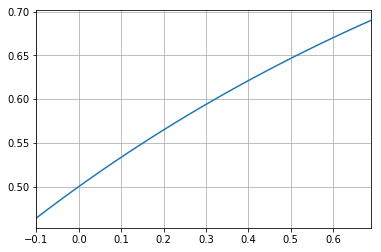

In [81]:
## we can construct a mapping between FA and hit rate

def FA_hitRate( FA, N= 10000):
    t= np.array([i/N for i in range( 1, N+1, 1)])**FA
    t= t/t.sum()
    
    return t[int(N/2):].sum()
    
pd.Series([FA_hitRate(FA= x/100) for x in range(-10, 70)] , index= np.array( range(-10, 70))/100).plot()
plt.grid()

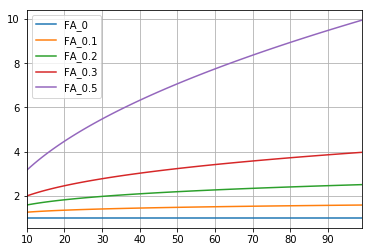

In [82]:
# tail odds= Prob(Best)/Prob(Worst)

d= {}
for M in range( 10,100):
    t= pd.Series([i/M for i in range(1, M+1)])
    t= pd.DataFrame({'rank': t, 
                     'FA_0': t**0, 
                     'FA_0.1': t**0.1, 
                     'FA_0.2': t**0.2, 
                     'FA_0.3': t**0.3, 
                      'FA_0.5': t**0.5, 
                      'FA_0.7': t**0.7, 
                      'FA_1.0': t
                    }) 
    t.set_index( 'rank', drop=True, inplace=True)
    t= t.div( t.sum(), axis=1)
    d.update({M: t.tail(1).mean() /t.head(1).mean()})
    
d= pd.DataFrame(d).T

d.iloc[:, :5].plot()
plt.grid()

In [83]:
t.tail(1).iloc[0, ]

FA_0      0.010101
FA_0.1    0.011082
FA_0.2    0.012068
FA_0.3    0.013058
FA_0.5    0.015042
FA_0.7    0.017027
FA_1.0    0.020000
Name: 1.0, dtype: float64

Manager selection skill can be defined by selection skewness (SS) Gabaix (2009). The manager $i$ with rank $k_i$ has probablity to be selected as 

$$
P_i= \frac{k_i^{SS}}{\sum_j{k_j^{SS}}}
$$

$SS $ ranges from 0 to $inf$

#### Management Fee Structure


Fundamental cost more than quant. High TE cost more than low TE.


Note: Encode the dimensions for convenience: 
  

    style: 1 (Growth), -1 (Value), 0 (Core)
    approach: 1 (Quant), -1 (Fundamental) 
    te: 1 (High), -1 (Low)
    
    
    


+ Fee Break Point 
    
    0- 50 Million
    
    50- 150 Million
    
    Larger than 150 Million

In [84]:
from cio_portfolio import managementFee


def maxDD (s): # pd Series
    
    t= pd.DataFrame( {'raw': s, 'rmax': s.rolling( window= s.shape[0]+1, min_periods= 1).max() })
    t['DD']= (t['raw']- t['rmax']) /t['rmax']
    
    return t['DD'].min()

So far we have got all information to run the simulation 

### Simulation Settings



In [85]:


# Param Setting


# PM_returns
AllManager_return = pd.concat( [USLC_Core_Ret, USLC_Value_Ret, USLC_Growth_Ret], axis=1) 

# PM_Info
AllManager_Info_D1= {} 
AllManager_Info_D3= {}
AllManager_return_filler= {}

for k,v in {**USLC_CoreFund, 
           ** USLC_ValueFund, 
           ** USLC_GrowthFund}.items():
    a= v.category.split('_')[1]
    b= v.approach
    c= v.TE_TercileWUA
    AllManager_Info_D3[v.EID]= {'style': 1 if a=='Growth' else(-1 if a=='Value' else 0), 
                              'approach': 1 if b=='Q' else -1, 
                              'te': 1 if c=='H' else -1}
    bm_name= 'R1000G' if a=='Growth' else ('R1000V' if a=='Value' else 'R1000')
    AllManager_return_filler[v.EID]= BM_Index[bm_name].ret
    
AllManager_Info_D1= pd.DataFrame(AllManager_Info_D3).T.drop(columns= ['approach', 'te']).T.to_dict()
AllManager_return_filler= pd.DataFrame( AllManager_return_filler)

# start and end dates
start_dates= ['1997-01-31', '2000-01-31', '2003-01-31', '2006-01-31', '2009-01-31', '2012-01-31', '2015-01-31']
end_dates=   ['1999-12-31', '2002-12-31', '2005-12-31', '2008-12-31', '2011-12-31', '2014-12-31', '2017-12-31']

inv_horizon= 3 # years
capital_initial= 1000 # 1000 million

# mg fee calculator

# managementFee_cal.mg_fee('614339', invested_capital= 100)

In [86]:
tmp_df= []
for k, v in D3_opposet_scheme.items():
    
    tmp_l= []
    i=1
    for t in v: 
        y= copy.deepcopy(t)
        y['mgr_count']=k
        y['aloc_ID']= str(k)+'_'+ str(i)
        y['factor']= y.index
        y.reset_index(drop= True, inplace= True)
        
        i=i+1
        tmp_l.append(y)
        
    tmp_df.append( pd.concat( tmp_l, axis=0))
    



In [87]:
D3_opposet_scheme[9][11]

,PM_1,PM_2,PM_3,PM_4,PM_5,PM_6,PM_7,PM_8,PM_9
approach,-1,1,1,-1,-1,1,-1,1,1
style,-1,-1,-1,0,0,0,1,1,1
te,-1,-1,1,-1,1,1,1,-1,1



#### Save the Simulation Settings 

In [88]:
sim_periods= [(start_dates[i], end_dates[i]) for i in range( len(start_dates))]

skill_sets= {'s00p': [0, True],
             's05p': [0.05, True],
             's10p': [0.10, True],
             's15p': [0.15, True], 
             's20p': [0.20, True], 
             's30p': [0.30, True], 
             's40p': [0.40, True], 
             's50p': [0.50, True], 
             's60p': [0.60, True], 
             's70p': [0.70, True],
             's00': [0, False],
             's05': [0.05, False],
             's10': [0.10, False],
             's15': [0.15, False], 
             's20': [0.20, False], 
             's30': [0.30, False], 
             's40': [0.40, False], 
             's50': [0.50, False], 
             's60': [0.60, False], 
             's70': [0.70, False],
             'n05': [-0.05, False], 
             'n10': [-0.10, False], 
             'n15': [-0.15, False]}

BM_returns= pd.DataFrame({k:v.ret for k,v in BM_Index.items()})
                          
pickle.dump( {'AllManager_return': AllManager_return, 
              'AllManager_Info_D1': AllManager_Info_D1, 
              'AllManager_Info_D3': AllManager_Info_D3, 
              'AllManager_return_filler': AllManager_return_filler,
              'D1_opposet_scheme': D1_opposet_scheme, 
              'D3_opposet_scheme': D3_opposet_scheme, 
              'Coreonly_opposet_scheme':{i: [pd.DataFrame({'style': {'PM_'+str(j):0 for j in range(1, i+1)}}).T] for i in D1_opposet_scheme.keys() }, 
              'sim_periods': sim_periods, 
              'skill_sets': skill_sets, 
              'BM_returns':  BM_returns, 
              'otherSimSettings': {'inv_horizon': inv_horizon,  
                                   'capital_initial': capital_initial, 
                                   # 'sim_count': sim_count
                                  }}, 
            open('AZsim_inputs.p', 'wb'))
'''
For each path we need to specify
1. D3/D1
2. Period
3. Skill
4. run index (i of sim_count) 
(5. target exposure ?)  
'''


'\nFor each path we need to specify\n1. D3/D1\n2. Period\n3. Skill\n4. run index (i of sim_count) \n(5. target exposure ?)  \n'

We set the run on Microsoft Azure and load the result from AZOutput


In [75]:
# load BIGGGGG AZSimResult file

AZSimRes_DF= pickle.load( open( 'AZSimResult_20190528.p', 'rb')).astype(float, errors= 'ignore')
Coreonly_DF= pickle.load( open( 'AZSimResult_CoreOnly_20190620.p', 'rb')).astype(float, errors= 'ignore')
AZSimRes_DF= pd.concat([AZSimRes_DF, 
                       Coreonly_DF], axis=0)
AZSimRes_DF['sce_numPM']= AZSimRes_DF.sce_numPM.astype(int)
AZSimRes_DF['Alpha_g']= AZSimRes_DF.Alpha+ AZSimRes_DF.MgFee
AZSimRes_DF['IR_g']= AZSimRes_DF.Alpha_g/ AZSimRes_DF.TE
AZSimRes_DF['sce_rebcount']= AZSimRes_DF.count_selection- AZSimRes_DF.sce_numPM
AZSimRes_DF['opct_rebalance']= 1/AZSimRes_DF.sce_numPM * (50/10000) * AZSimRes_DF.sce_rebcount* 1/3
AZSimRes_DF['opct_mgrcount']= AZSimRes_DF.sce_numPM**2 * (0.1/10000)

AZSimRes_DF['Alpha_nopc']= AZSimRes_DF['Alpha']- AZSimRes_DF['opct_rebalance']- AZSimRes_DF['opct_mgrcount']
AZSimRes_DF['IR_nopc']= AZSimRes_DF['Alpha_nopc']/ AZSimRes_DF['TE']
AZSimRes_DF['TE_mul']= 5
AZSimRes_DF['TE_sq']= AZSimRes_DF['TE']**2
AZSimRes_DF['Alpha_adj']= AZSimRes_DF['Alpha_nopc']- AZSimRes_DF['TE_mul']* (AZSimRes_DF['TE']**2) 

# test1: no rebalance cost
AZSimRes_DF['test1_alpha']= AZSimRes_DF['Alpha']- AZSimRes_DF['opct_mgrcount']
AZSimRes_DF['test1_IR']= AZSimRes_DF['test1_alpha']/ AZSimRes_DF['TE']

# test2: no operation cost
AZSimRes_DF['test2_alpha']= AZSimRes_DF['Alpha']- AZSimRes_DF['opct_rebalance']
AZSimRes_DF['test2_IR']= AZSimRes_DF['test2_alpha']/AZSimRes_DF['TE']


# test3: linear operation cost with multiplier 2 (bps) and real fee rate and rebalance cost 
AZSimRes_DF['test3_opctmgr']=  AZSimRes_DF['sce_numPM']* (2/10000)
AZSimRes_DF['test3_alpha']= AZSimRes_DF['Alpha']-AZSimRes_DF['opct_rebalance'] - AZSimRes_DF['test3_opctmgr']
AZSimRes_DF['test3_IR']= AZSimRes_DF['test3_alpha']/AZSimRes_DF['TE']

# test4: linear opeartion cost and constant fee rate 50 bps across invested capital and manager type and rebalance cost
AZSimRes_DF['test4_alpha']= AZSimRes_DF['Alpha_g']- (50/10000)- AZSimRes_DF['opct_rebalance']- AZSimRes_DF['test3_opctmgr']
AZSimRes_DF['test4_IR']= AZSimRes_DF['test4_alpha']/ AZSimRes_DF['TE']

# 






AZSimRes_mean= AZSimRes_DF.groupby( ['sce_numPM', 'sce_skillSet','sce_optDim' ,]).mean()
AZSimRes_std=  AZSimRes_DF.groupby( ['sce_numPM', 'sce_skillSet','sce_optDim' ,]).std()
AZSimRes_std.columns= ['std:'+ x for x in AZSimRes_std.columns]
AZSimRes_skew= AZSimRes_DF.groupby( ['sce_numPM', 'sce_skillSet','sce_optDim' ,]).skew()
AZSimRes_skew.columns= ['skew:'+ x for x in AZSimRes_skew.columns]

AZSimRes_stats= pd.concat( [AZSimRes_mean, 
                            AZSimRes_std, 
                            AZSimRes_skew,
                           ], axis=1).reset_index()


writer= pd.ExcelWriter ('AZSimResult.xlsx')
AZSimRes_stats.to_excel(writer, sheet_name= 'AZSimRet_stats')
writer.save()


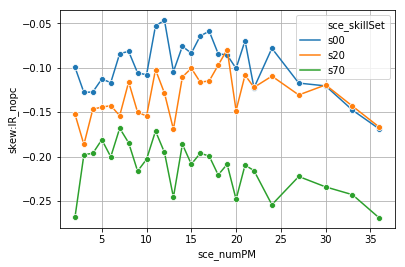

In [89]:
a= AZSimRes_stats.loc[AZSimRes_stats.sce_optDim=='D3', ]
a= a.loc[[x in ('s00', 's20', 's70') for x in a.sce_skillSet] , ]

sns.lineplot( data= a, x= 'sce_numPM',  y='skew:IR_nopc', hue= 'sce_skillSet', marker= 'o')
plt.grid()

In [90]:
AZSimRes_DF.columns

Index(['Alpha', 'IR', 'MgFee', 'TE', 'TR_net', 'count_selection',
       'exp_approach', 'exp_style', 'exp_te', 'sce_optDim', 'sce_skillSet',
       'sce_periodEnd', 'sce_numPM', 'sce_runCount', 'Alpha_g', 'IR_g',
       'sce_rebcount', 'opct_rebalance', 'opct_mgrcount', 'Alpha_nopc',
       'IR_nopc', 'TE_mul', 'TE_sq', 'Alpha_adj', 'test1_alpha', 'test1_IR',
       'test2_alpha', 'test2_IR', 'test3_opctmgr', 'test3_alpha', 'test3_IR',
       'test4_alpha', 'test4_IR'],
      dtype='object')

In [ ]:
a= AZSimRes_stats.loc[[x in ('n10', 
                             's00', 
                             # 's10', 
                             's20', 
                             # 's40', 
                             's70') for x in AZSimRes_stats.sce_skillSet],]
a= a.loc[a.sce_numPM<=24, ]
tmp_label= a.sce_skillSet.apply(lambda x: 'v:-0.1' if x=='n10' else 'v:'+ str(int(x[1:])/100) )
a.sce_skillSet= tmp_label
a.rename(columns= {'sce_skillSet': 'v', 
                  'sce_optDim': 'MAP_type'}, inplace= True)
a['Alpha_nopc_bps']= a['Alpha_nopc']*10000
a= a.loc[a.sce_numPM<=15]
a= a.loc[[x in ('D1', 'D3') for x in a.MAP_type], ]
fig= plt.figure(figsize= (15, 6))

# net alpha
ax= plt.subplot(121)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='Alpha_nopc_bps', 
    hue= 'v',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'Alpha_nopc_bps']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['Alpha_nopc_bps'].idxmax(), :]).reset_index(drop=True)

# try: 
#     b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='o',color='black', linewidth= 2 ,ax= ax  )
# except: 
#     pass

# try:
#     b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
# except: 
#     pass


ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'Alpha (bps, net of fees and operation cost)')
ax.set_title('Portfolio Active Return')
ax.grid()


# net of fee and operation cost IR
ax= plt.subplot(122)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='IR_nopc', 
    hue= 'v',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'IR_nopc']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['IR_nopc'].idxmax(), :]).reset_index(drop=True)
try: 
    b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',color='black', linewidth= 2 ,ax= ax  )
except: 
    pass

try:
    b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
except: 
    pass
ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'IR (net of fees and operation cost)')
ax.set_title( 'Portfolio Active Return, Adjusted to Risk')
ax.grid()



plt.savefig( 'sim_net_plot.jpg')

In [ ]:
a= AZSimRes_stats.loc[[x in (
                             's00', 
                             # 's10', 
                             's20', 
                             # 's40', 
                             's70') for x in AZSimRes_stats.sce_skillSet],]
a= a.loc[a.sce_numPM<=24, ]
tmp_label= a.sce_skillSet.apply(lambda x: 'v:-0.1' if x=='n10' else 'v:'+ str(int(x[1:])/100) )
a.sce_skillSet= tmp_label
a.rename(columns= {'sce_skillSet': 'v', 
                  'sce_optDim': 'MAP_type'}, inplace= True)
a['Alpha_nopc_bps']= a['Alpha_nopc']*10000
a= a.loc[a.sce_numPM<=15]
a= a.loc[[x in (
    # 'D1', 
    'D3') for x in a.MAP_type], ]
fig= plt.figure(figsize= (15, 6))

# net alpha
ax= plt.subplot(121)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='Alpha_nopc_bps', 
    hue= 'v',
    # style= 'MAP_type',
    marker= 'o',
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'Alpha_nopc_bps']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['Alpha_nopc_bps'].idxmax(), :]).reset_index(drop=True)

# try: 
#     b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='o',color='black', linewidth= 2 ,ax= ax  )
# except: 
#     pass

# try:
#     b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
# except: 
#     pass


ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'Alpha (bps, net of fees and operation cost)')
ax.set_title('Portfolio Active Return')
ax.grid()


# net of fee and operation cost IR
ax= plt.subplot(122)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='IR_nopc', 
    hue= 'v',
    # style= 'MAP_type',
    marker= 'o',
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'IR_nopc']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['IR_nopc'].idxmax(), :]).reset_index(drop=True)
try: 
    b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',color='black', linewidth= 2 ,ax= ax  )
except: 
    pass

try:
    b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',markersize= 10,color='red', linewidth= 2 ,linestyle= '--', ax= ax  )
except: 
    pass
ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'IR (net of fees and operation cost)')
ax.set_title( 'Portfolio Active Return, Adjusted to Risk')
ax.grid()




C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

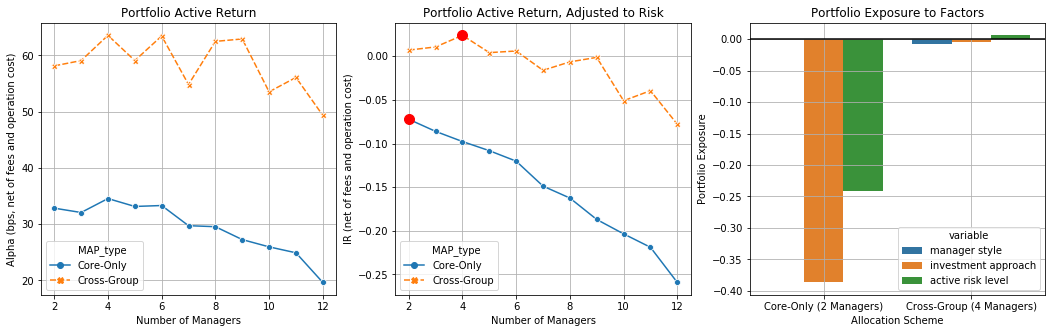

In [86]:
a= AZSimRes_stats.loc[[x in ('n10', 
                             's00', 
                             # 's10', 
                             's20', 
                             # 's40', 
                             's70') for x in AZSimRes_stats.sce_skillSet],]

tmp_label= a.sce_skillSet.apply(lambda x: 'v:-0.1' if x=='n10' else 'v:'+ str(int(x[1:])/100) )
a.sce_skillSet= tmp_label
a.rename(columns= {'sce_skillSet': 'v', 
                  'sce_optDim': 'MAP_type'}, inplace= True)
a['Alpha_nopc_bps']= a['Alpha_nopc']*10000
a= a.loc[a.sce_numPM<=12]
tmp= a.MAP_type.apply(lambda x: 'Core-Only' if x=='Coreonly' else('AS1' if x=='D1' else 'Cross-Group'))
a['MAP_type']= tmp
a= a.loc[a.MAP_type!= 'AS1', ]


fig= plt.figure(figsize= (18, 5))
# net alpha
ax= plt.subplot(131)
sns.lineplot(data= a.loc[a.v=='v:0.0', ], 
    x= 'sce_numPM', 
    y='Alpha_nopc_bps', 
    hue= 'MAP_type',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'Alpha_nopc_bps']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['Alpha_nopc_bps'].idxmax(), :]).reset_index(drop=True)

# try: 
#     b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='o',color='black', linewidth= 2 ,ax= ax  )
# except: 
#     pass

# try:
#     b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
# except: 
#     pass


ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'Alpha (bps, net of fees and operation cost)')
ax.set_title('Portfolio Active Return')
ax.grid()


# net of fee and operation cost IR
ax= plt.subplot(132)
sns.lineplot(data= a.loc[a.v=='v:0.0', ], 
    x= 'sce_numPM', 
    y='IR_nopc', 
    hue= 'MAP_type',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a.loc[a.v=='v:0.0',['v',
   'MAP_type',
   'sce_numPM' ,
   'IR_nopc']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['IR_nopc'].idxmax(), :]).reset_index(drop=True)
try:
    b.loc[b.MAP_type=='Core-Only', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',color='red', linewidth= 2 ,linestyle= '--', markersize=10, ax= ax  )
except: 
    pass

try: 
    b.loc[b.MAP_type=='AS1', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',color='red', linewidth= 2, markersize= 10 ,ax= ax  )
except: 
    pass

try:
    b.loc[b.MAP_type=='Cross-Group', ].plot(x= 'sce_numPM', y= 'IR_nopc', marker='o',color='red', linewidth= 2 ,linestyle= '--', markersize=10, ax= ax  )
except: 
    pass
ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'IR (net of fees and operation cost)')
ax.set_title( 'Portfolio Active Return, Adjusted to Risk')
ax.grid()


ax= plt.subplot(133)
exp_df= a.loc[a.v=='v:0.0', ].groupby(['MAP_type', 'sce_numPM', ]).mean().loc[[('Core-Only', 2), 
                                                                              #  ('AS1', 2), 
                                                                               ('Cross-Group', 4)], 
                                                                              ['exp_style', 'exp_approach', 'exp_te', 'TE']].reset_index()
exp_df['MAP_type']= ['Core-Only (2 Managers)', 
                    # 'AS1 (2 Managers)', 
                    'Cross-Group (4 Managers)']
exp_df.rename( columns= {'exp_style': 'manager style', 
                        'exp_approach': 'investment approach', 
                        'exp_te': 'active risk level'}, inplace= True)

sns.barplot(data= pd.melt( exp_df, id_vars= ['MAP_type'], value_vars= ['manager style', 'investment approach', 'active risk level'] ), 
            x='MAP_type', y= 'value', hue= 'variable', ax=ax)  
ax.axhline(0, color= 'k')
ax.set_xlabel( 'Allocation Scheme')
ax.set_ylabel( 'Portfolio Exposure')
ax.set_title( 'Portfolio Exposure to Factors')
ax.grid()

C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


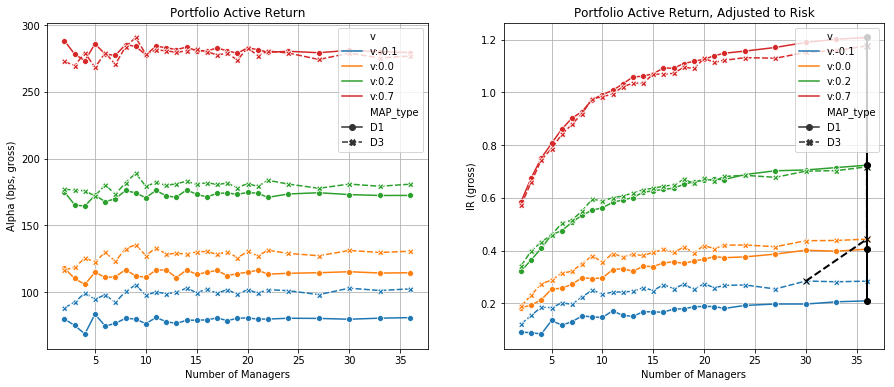

In [109]:
a= AZSimRes_stats.loc[[x in ('n10', 
                             's00', 
                             # 's10', 
                             's20', 
                             # 's40', 
                             's70') for x in AZSimRes_stats.sce_skillSet],]

tmp_label= a.sce_skillSet.apply(lambda x: 'v:-0.1' if x=='n10' else 'v:'+ str(int(x[1:])/100) )
a.sce_skillSet= tmp_label
a.rename(columns= {'sce_skillSet': 'v', 
                  'sce_optDim': 'MAP_type'}, inplace= True)
a['Alpha_gross_bps']= a['Alpha_g']*10000
# a= a.loc[a.sce_numPM<=15]
a= a.loc[[x in ('D1', 'D3') for x in a.MAP_type], ]
fig= plt.figure(figsize= (15, 6))



# net alpha
ax= plt.subplot(121)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='Alpha_gross_bps', 
    hue= 'v',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'Alpha_gross_bps']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['Alpha_gross_bps'].idxmax(), :]).reset_index(drop=True)

# try: 
#     b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='o',color='black', linewidth= 2 ,ax= ax  )
# except: 
#     pass

# try:
#     b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'Alpha_nopc_bps', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
# except: 
#     pass


ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'Alpha (bps, gross)')
ax.set_title('Portfolio Active Return')
ax.grid()


# net of fee and operation cost IR
ax= plt.subplot(122)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='IR_g', 
    hue= 'v',
    style= 'MAP_type',
    markers= True,
    ax= ax)

b= a[['v',
   'MAP_type',
   'sce_numPM' ,
   'IR_g']].groupby(['v', 'MAP_type']).apply(
        lambda x: x.loc[ x['IR_g'].idxmax(), :]).reset_index(drop=True)
try: 
    b.loc[b.MAP_type=='D1', ].plot(x= 'sce_numPM', y= 'IR_g', marker='o',color='black', linewidth= 2 ,ax= ax  )
except: 
    pass

try:
    b.loc[b.MAP_type=='D3', ].plot(x= 'sce_numPM', y= 'IR_g', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
except: 
    pass
ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'IR (gross)')
ax.set_title( 'Portfolio Active Return, Adjusted to Risk')
ax.grid()



plt.savefig( 'sim_gross_plot.jpg')

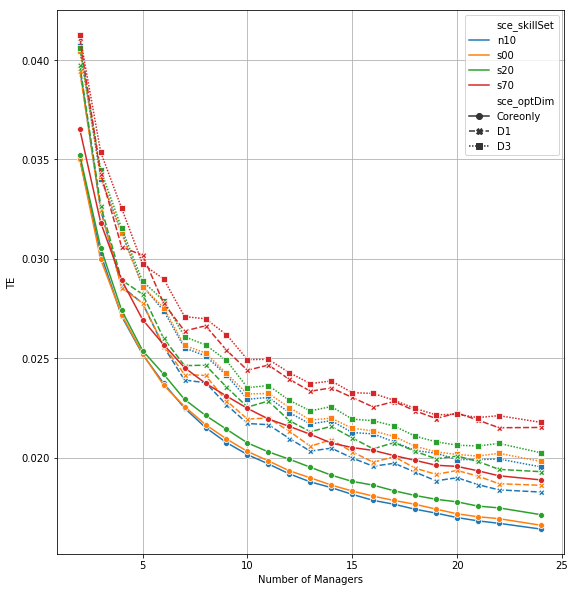

In [88]:
a= AZSimRes_stats.loc[[x in ('n10', 
                             's00', 
                             # 's10', 
                             's20', 
                             # 's40', 
                             's70') for x in AZSimRes_stats.sce_skillSet],]
a= a.loc[a.sce_numPM<=24, ]
fig= plt.figure(figsize= (20, 10))

# TE
ax= plt.subplot(121)
sns.lineplot(data= a, 
    x= 'sce_numPM', 
    y='TE', 
    hue= 'sce_skillSet',
    style= 'sce_optDim',
    markers= True,
    ax= ax)

# b= a[['sce_skillSet',
#    'sce_optDim',
#    'sce_numPM' ,
#    'TE']].groupby(['sce_skillSet', 'sce_optDim']).apply(
#         lambda x: x.loc[ x['TE'].idxmax(), :]).reset_index(drop=True)
# try: 
#     b.loc[b.sce_optDim=='D1', ].plot(x= 'sce_numPM', y= 'TE', marker='o',color='black', linewidth= 2 ,ax= ax  )
# except: 
#     pass

# try:
#     b.loc[b.sce_optDim=='D3', ].plot(x= 'sce_numPM', y= 'TE', marker='x',color='black', linewidth= 2 ,linestyle= '--', ax= ax  )
# except: 
#     pass


ax.set_xlabel( 'Number of Managers')
ax.set_ylabel( 'TE')
ax.grid()


plt.savefig( 'sim_TE_plot.jpg')

Text(0, 0.5, 'Average Management Fee (bps)')

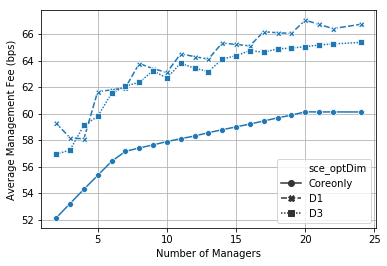

In [89]:
# plt.figure(figsize= ( 10, 8))
tmp= a.groupby(['sce_numPM','sce_optDim']).mean().reset_index() 
tmp['MgFee']= tmp.MgFee*10000
sns.lineplot(data= tmp, y= 'MgFee', x= 'sce_numPM', style='sce_optDim', markers=True)
plt.grid()
plt.xlabel( 'Number of Managers')
plt.ylabel( 'Average Management Fee (bps)')

Text(0, 0.5, 'Average Management Fee Difference (D1-D3)')

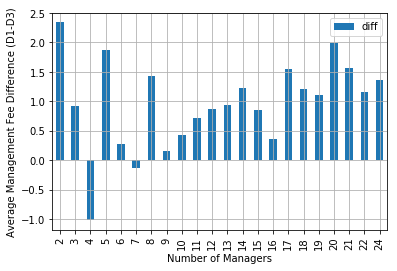

In [90]:
MgFee_df= tmp.loc[tmp.sce_optDim=='D1', ['sce_numPM','MgFee']]
MgFee_df.rename({'MgFee': 'MgFee_D1'}, axis=1, inplace= True)
t= tmp.loc[tmp.sce_optDim=='D3', ['sce_numPM','MgFee']]
t.rename({'MgFee': 'MgFee_D3'}, axis=1, inplace= True)

MgFee_df= MgFee_df.merge( t, how= 'left', on= 'sce_numPM')
MgFee_df['diff']= MgFee_df.MgFee_D1- MgFee_df.MgFee_D3

MgFee_df.plot.bar(x='sce_numPM', y ='diff')
plt.grid()

plt.xlabel('Number of Managers')
plt.ylabel('Average Management Fee Difference (D1-D3)')

**Is the improvement of D3 compared to D1 material or just noise?**

Thanks to CLT we can estimate the distribution of average IR by Normal

C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\x213114\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

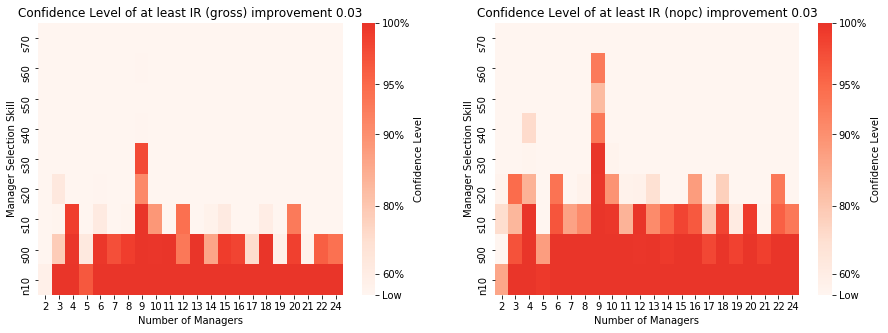

In [91]:
import scipy.stats

t= AZSimRes_stats[['sce_numPM', 'sce_skillSet', 'sce_optDim', 'IR_g', 'IR_nopc', 'std:IR_g', 'std:IR_nopc']]
t['N']= AZSimRes_DF.shape[0]/AZSimRes_stats.shape[0]
t['distvar:IR_g']= (t['std:IR_g']**2) /t['N']
t['distvar:IR_nopc']= (t['std:IR_nopc']**2) / t['N']
t= t.loc[[x in ( 'n10', 's00', 's10' ,'s20', 's30', 's40', 's50', 's60', 's70' ) for x in t.sce_skillSet], ]
t= t.loc[t.sce_numPM<=24, ]

t_D1= t.loc[t.sce_optDim=='D1', ].drop(columns= ['sce_optDim']).set_index(['sce_numPM', 'sce_skillSet'])
t_D3= t.loc[t.sce_optDim=='D3', ].drop(columns= ['sce_optDim']).set_index( ['sce_numPM','sce_skillSet'])

t_diff= t_D3-t_D1
t_diff= t_diff[['IR_g', 'IR_nopc']]
t_diff['diststd:IR_g']= (t_D1['distvar:IR_g']+ t_D3['distvar:IR_g'])**.5
t_diff['diststd:IR_nopc']= (t_D1['distvar:IR_nopc']+ t_D3['distvar:IR_nopc'])**.5

improvement_target= 0.03
t_diff['diststats:IR_g']= (t_diff['IR_g']- improvement_target)/ t_diff['diststd:IR_g']
t_diff['diststats:IR_nopc']= (t_diff['IR_nopc']- improvement_target)/ t_diff['diststd:IR_nopc']

standardNormal= scipy.stats.norm(0,1)
t_diff['prob:IR_g']= standardNormal.cdf(t_diff['diststats:IR_g'])
t_diff['prob:IR_nopc']= standardNormal.cdf(t_diff['diststats:IR_nopc'])

# t_diff['prob:IR_g']= 

t_diff.reset_index(drop=False, inplace= True)

stats_IR_g= t_diff.pivot( columns= 'sce_numPM', index= 'sce_skillSet', values='prob:IR_g')
stats_IR_nopc= t_diff.pivot( columns='sce_numPM', index= 'sce_skillSet', values= 'prob:IR_nopc')

plt.figure( figsize=( 15, 5))
ax= plt.subplot(121)
sns.heatmap(data= stats_IR_g.sort_index(ascending= False)**5, cmap= 'Reds', ax= ax, center=0.95**5,
            cbar_kws={'label': 'Confidence Level'})
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.array([0,0.6 , 0.8, 0.9, 0.95,1])**5)
cbar.set_ticklabels(['Low', '60%', '80%', '90%','95%', '100%'])
ax.set_xlabel('Number of Managers')
ax.set_ylabel('Manager Selection Skill')
ax.set_title( 'Confidence Level of at least IR (gross) improvement '+ str(improvement_target))

ax= plt.subplot(122)
sns.heatmap(data= stats_IR_nopc.sort_index(ascending= False)**5, cmap= 'Reds', ax= ax, center= 0.95**5,
            cbar_kws={'label': 'Confidence Level'})
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.array([0,0.6, 0.8, 0.9, 0.95,1])**5)
cbar.set_ticklabels(['Low', '60%', '80%', '90%','95%', '100%'])
ax.set_xlabel('Number of Managers')
ax.set_ylabel('Manager Selection Skill')
ax.set_title( 'Confidence Level of at least IR (nopc) improvement '+str(improvement_target))

plt.savefig( 'IR_improvement_sig.jpg')

### Simple Example of Four Managers


Creat a simple example of four managers for illustration purpose. 

Compare Three Allocation Schemes: 

    AS0: Four Managers from Core group. 
    AS1: Two from Core, One from Growth, One From Value
    AS2: Core+F+L (0_-1_-1), Core+Q+L (0_1_-1), Value+Q+H (-1_1_1), Growth+F+H (1_-1_1) 
    
Assume the manager picking is random. Apply the same fee structure, 3y investment periods and AUM 1000 mm$ as above

In [ ]:
# from cio_portfolio import CIO_portfolio_v2, managementFee, manager_selector
# import time


# # management fee calculator
# managementFee_cal= managementFee(manager_Info= AllManager_Info_D3)


# # manager selector
# manager_picker_AS0= manager_selector(selection_skill= 0, 
#                                      selection_survival= False, 
#                                      manager_dimension_scheme={i: [pd.DataFrame({'style': {'PM_'+str(j):0 for j in range(1, i+1)}}).T] for i in range(2, 16)}, 
#                                      manager_return_filler= AllManager_return_filler)


# # capital allocation
# capital_initial= 1000
# M=10

# resultDict= {}
# resultSum= []


# t0= time.time()
# for numPM in range(2, 16): 
#     capital_allocation= {'PM_'+str(i): 1/ numPM* capital_initial for i in range(1, numPM+1,1) }
#     for inv_period in sim_periods: 
#         sim_params= {'start_date': inv_period[0], 
#                     'end_date': inv_period[1], 
#                     'invest_horizon': 3, 
#                     'capital_allocation': capital_allocation, 
#                     'managerFee_calculator': managementFee_cal, 
#                     'PM_returns': AllManager_return, 
#                     'bm_ret': BM_returns['R1000'],
#                     }
#         scenario_str_AS0= 'AS0+'+inv_period[1]+'+'
#         print(str(numPM)+'  '+inv_period[0]+ ' running.......')
#         tmpDict_AS0= {scenario_str_AS0+ str(i): CIO_portfolio_v2(ID= scenario_str_AS0+ str(i),
#                                                                  PM_picker= manager_picker_AS0, 
#                                                                  PM_Info= AllManager_Info_D1 ,
#                                                                  **sim_params)   for i in range(M)}


#         print(inv_period[0]+ ' done!')

#         tmpDict= tmpDict_AS0

#         result_df= pd.DataFrame({k: {'Alpha': v.alpha_net,
#                                       'TE': v.te,
#                                       'IR': v.IR_net,
#                                       'TR_net': v.annualReturn_net,
#                                       'MgFee': v.annualFee,
#                                       'count_selection': int(pd.DataFrame(v.PMSelection_log).count().sum()),
#                                       } for k,v in tmpDict.items()}).T
#         exp_df = pd.DataFrame({k: v.portfolio_exposure(AllManager_Info_D3)[0].mean() for k, v in tmpDict.items()}).T
#         exp_df.columns = ['exp_' + x for x in exp_df.columns]
#         info_df = pd.DataFrame(
#             {k: k.split('+') for k in result_df.index},
#             index=[
#                 'sce_scheme',
#                 'sce_periodEnd',
#                 'sce_runCount']).T
#         info_df['sce_numPM']= numPM
#         result_df = pd.concat([result_df, exp_df, info_df], axis=1).astype(float, errors='ignore')

#         resultSum.append(result_df)
#         resultDict.update(tmpDict)
    
# resultSum= pd.concat(resultSum, axis=0)

# pickle.dump( resultSum, open('resultDF_example_AS0.p', 'wb'))
# pickle.dump( resultDict, open('resultDict_example_AS0.p', 'wb'))


# print(time.time()- t0)

In [82]:
resultSum= pickle.load(open('resultDF_example_4.p', 'rb'))

resultSum['Alpha_g']= resultSum.Alpha+ resultSum.MgFee
resultSum['IR_g']= resultSum.Alpha_g/ resultSum.TE
resultSum['sce_rebcount']= resultSum.count_selection- resultSum.sce_numPM
resultSum['opct_rebalance']= 1/resultSum.sce_numPM * (50/10000) * resultSum.sce_rebcount* 1/3
resultSum['opct_mgrcount']= resultSum.sce_numPM**2 * (0.1/10000)

resultSum['Alpha_nopc']= resultSum.Alpha- resultSum['opct_rebalance']- resultSum['opct_mgrcount']
resultSum['IR_nopc']= resultSum['Alpha_nopc']/ resultSum['TE']

resultSum_mean= resultSum.groupby(['sce_scheme']).mean()
resultSum_std= resultSum.groupby( ['sce_scheme']).std()
resultSum_std.columns= ['std:'+ x for x in resultSum_std.columns]
resultSum_stats= pd.concat( [resultSum_mean, resultSum_std], axis=1).reset_index()



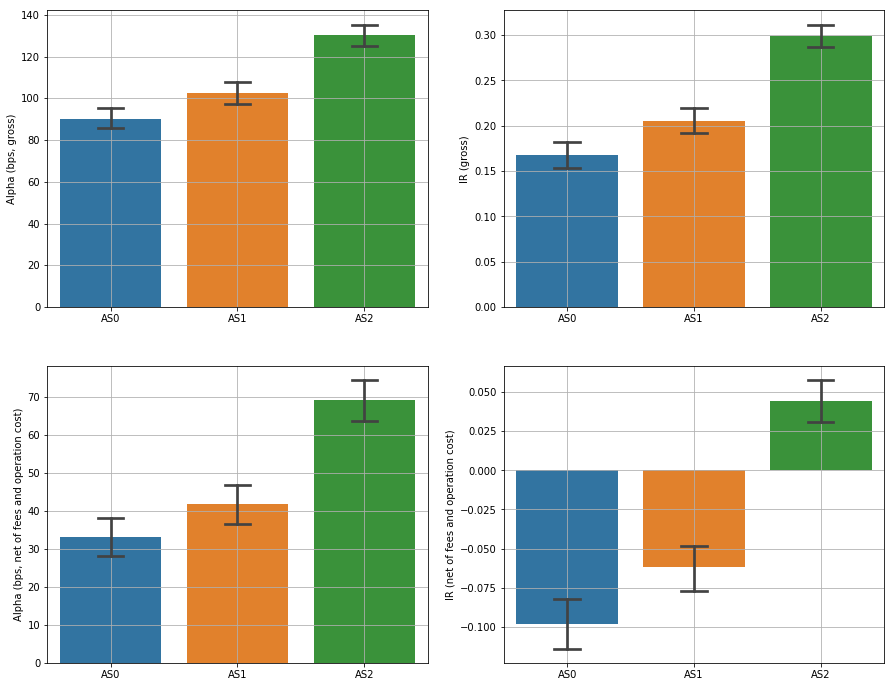

In [83]:
plt.figure(figsize=(15, 12))


ax= plt.subplot(221)
sns.barplot(data= pd.DataFrame({'sce_scheme': resultSum.sce_scheme, 
                               'Alpha_g': resultSum.Alpha_g* 10000}), x= 'sce_scheme', y= 'Alpha_g', ci=95, capsize= .2, ax= ax)
ax.set_xlabel( '')
ax.set_ylabel( 'Alpha (bps, gross)')
ax.grid()

ax= plt.subplot(222)
sns.barplot(data= resultSum, x= 'sce_scheme', y= 'IR_g', ci= 95, capsize= 0.2, ax=ax)
ax.set_xlabel( '')
ax.set_ylabel( 'IR (gross)')
ax.grid()


ax= plt.subplot(223)
sns.barplot(data= pd.DataFrame({'sce_scheme': resultSum.sce_scheme, 
                               'Alpha_nopc': resultSum.Alpha_nopc* 10000}), x= 'sce_scheme', y= 'Alpha_nopc', ci=95, capsize= .2, ax= ax)
ax.set_xlabel( '')
ax.set_ylabel( 'Alpha (bps, net of fees and operation cost)')
ax.grid()


ax= plt.subplot(224)
sns.barplot(data= resultSum, x= 'sce_scheme', y= 'IR_nopc', ci= 95, capsize= 0.2, ax=ax)
ax.set_xlabel( '')
ax.set_ylabel( 'IR (net of fees and operation cost)')
ax.grid()


plt.savefig( 'example4_result_bar.jpg')

Text(0.5, 1.0, 'Portfolio Active Return, Adjusted to Risk')

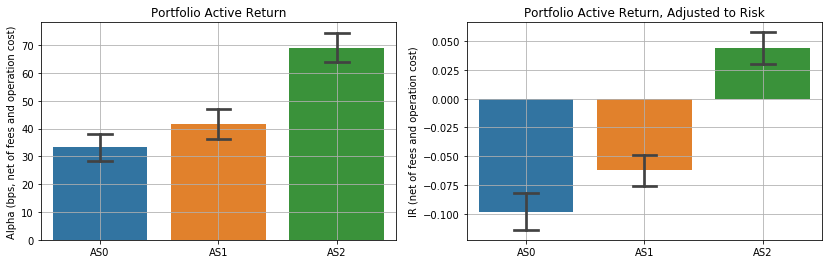

In [84]:
plt.figure(figsize=(14,4))
ax= plt.subplot(121)
sns.barplot(data= pd.DataFrame({'sce_scheme': resultSum.sce_scheme, 
                               'Alpha_nopc': resultSum.Alpha_nopc* 10000}), x= 'sce_scheme', y= 'Alpha_nopc', ci=95, capsize= .2, ax= ax)
ax.set_xlabel( '')
ax.set_ylabel( 'Alpha (bps, net of fees and operation cost)')
ax.grid()
ax.set_title('Portfolio Active Return')

ax= plt.subplot(122)
sns.barplot(data= resultSum, x= 'sce_scheme', y= 'IR_nopc', ci= 95, capsize= 0.2, ax=ax)
ax.set_xlabel( '')
ax.set_ylabel( 'IR (net of fees and operation cost)')
ax.grid()
ax.set_title( 'Portfolio Active Return, Adjusted to Risk')


Text(0.5, 1.0, 'Portfolio Exposure')

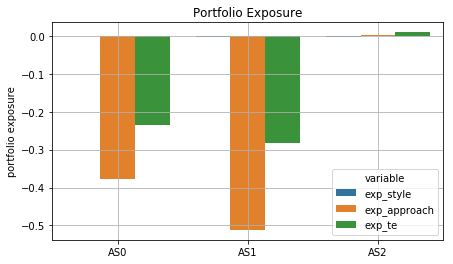

In [85]:
plt.figure(figsize=(7,4))
ax= sns.barplot(data= pd.melt( resultSum, id_vars=['sce_scheme'], value_vars= ['exp_style', 'exp_approach', 'exp_te']), 
            x= 'sce_scheme', y='value', hue='variable', ci=0, )
# ax.axhline(0, color= 'k')
ax.set_xlabel( '')
ax.set_ylabel( 'portfolio exposure')
ax.grid()
plt.savefig( 'example4_exp_bar.jpg')
ax.set_title('Portfolio Exposure')